# Week 8 - Semantic & Influence Networks

This week, we explore the representation and analysis of semantic networks. A word or document network is an unsupervized representation of text akin to a clustering or an embedding, but semantic networks can also be defined using semantic or syntactic information derived from methods we have used earlier in the quarter. For example, we can define links between words as a function of their co-presence within a document, chapter, paragraph, sentence, noun phrase or continuous bag of words. We can also define links as a function of words that rely on one another within a directed dependency parse, or links between extracted Subjects, Verbs and Objects, or nouns and the adjectives that modify them (or verbs and the adverbs that modify *them*). Rendering words linked as a network or discrete topology allows us to take advantage of the wide range of metrics and models developed for network analysis. These include measurement of network centrality, density and modularity, "block modeling" structurally equivalent relationships, andsophisticated graphical renderings of networks or network partitions that allow us to visually interrogate their structure and complexity.

For this notebook we will use the following packages:

In [1]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+git://github.com/Computational-Content-Analysis-2018/lucem_illud.git

#All these packages need to be installed from pip

#This will be doing most of the work
import networkx as nx

import nltk #For POS tagging
import sklearn #For generating some matrices
import pandas #For DataFrames
import numpy as np #For arrays
import matplotlib.pyplot as plt #For plotting
import seaborn #Makes the plots look nice
import scipy #Some stats

import pickle #if you want to save layouts
import os

%matplotlib inline

# An Introduction to networks in *networkx*

We will primarily be dealing with graphs in this notebook, so lets first go over how to use them.

To start with lets create an undirected graph:

In [2]:
g = nx.Graph()
g

We can add nodes. These are all named, like entries in a dictionary.

In [3]:
g.add_node(1)
g.add_node(2)
g.add_node(3)

Now we have 3 vertices:

In [4]:
len(g.nodes)

3

Or if we want to get more information about the graph:

In [5]:
print(nx.info(g))

Name: 
Type: Graph
Number of nodes: 3
Number of edges: 0
Average degree:   0.0000


We can give nodes properties, like name or type

In [6]:
g.nodes[1]

{}

In [7]:
g.nodes[1]['type'] = 'NN'

In [8]:
g.nodes[1]

{'type': 'NN'}

In [9]:
g.nodes[2]['name'] = 'dog'

In [10]:
g.nodes[2]

{'name': 'dog'}

Still pretty boring...

Lets add a couple of edges. Notice that we use the ids, but not any of the properties:

In [11]:
g.add_edges_from([(1, 2), (2, 3), (3, 1), (1,4)])
print(nx.info(g))

Name: 
Type: Graph
Number of nodes: 4
Number of edges: 4
Average degree:   2.0000


Note how the summary has changed. Moreover, there's one additional node, because we asked for an edge to 4.

We can also give the edges properties like weights:

In [12]:
g.edges[1, 2]['weight'] = 2
g.edges[1, 4]['weight'] = 2
g.edges[1, 4]

{'weight': 2}

Let's visualize our graph now:

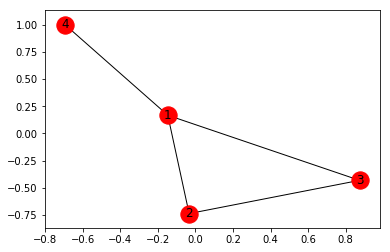

In [13]:
nx.draw_networkx(g)
plt.savefig("test.png")

Very exciting :-).

There are many things to do with the graph once we have created it, some of which we will explore here.

First let's load some data, like the Grimmer Senate press releases corpus:

In [14]:
senReleasesDF = pandas.read_csv('../data/senReleasesTraining.csv', index_col = 0)
senReleasesDF[:3]

download_url  \
0  https://raw.githubusercontent.com/lintool/Grim...   
1  https://raw.githubusercontent.com/lintool/Grim...   
2  https://raw.githubusercontent.com/lintool/Grim...   

                                            html_url                    name  \
0  https://github.com/lintool/GrimmerSenatePressR...  01Apr2005Kennedy14.txt   
1  https://github.com/lintool/GrimmerSenatePressR...  01Aug2005Kennedy12.txt   
2  https://github.com/lintool/GrimmerSenatePressR...  01Aug2006Kennedy10.txt   

                                 path  \
0  raw/Kennedy/01Apr2005Kennedy14.txt   
1  raw/Kennedy/01Aug2005Kennedy12.txt   
2  raw/Kennedy/01Aug2006Kennedy10.txt   

                                                text targetSenator  
0           FOR IMMEDIATE RELEASE   FOR IMMEDIATE...       Kennedy  
1           FOR IMMEDIATE RELEASE   FOR IMMEDIATE...       Kennedy  
2           FOR IMMEDIATE RELEASE  FOR IMMEDIATE ...       Kennedy

We will be extracting sentences, as well as tokenizing and stemming. (You should be able to do this in your sleep now).

In [15]:
senReleasesDF['tokenized_sents'] = senReleasesDF['text'].apply(lambda x: [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
senReleasesDF['normalized_sents'] = senReleasesDF['tokenized_sents'].apply(lambda x: [lucem_illud.normalizeTokens(s, stopwordLst = lucem_illud.stop_words_basic, stemmer = lucem_illud.stemmer_basic) for s in x])

Let's begin by looking at words that co-occur in the same sentences:

In [16]:
def wordCooccurrence(sentences, makeMatrix = False):
    words = set()
    for sent in sentences:
        words |= set(sent)
    wordLst = list(words)
    wordIndices = {w: i for i, w in enumerate(wordLst)}
    wordCoCounts = {}
    #consider a sparse matrix if memory becomes an issue
    coOcMat = np.zeros((len(wordIndices), len(wordIndices)))
    for sent in sentences:
        for i, word1 in enumerate(sent):
            word1Index = wordIndices[word1]
            for word2 in sent[i + 1:]:
                coOcMat[word1Index][wordIndices[word2]] += 1
    if makeMatrix:
        return coOcMat, wordLst
    else:
        coOcMat = coOcMat.T + coOcMat
        g = nx.convert_matrix.from_numpy_matrix(coOcMat)
        g = nx.relabel_nodes(g, {i : w for i, w in enumerate(wordLst)})
        return g

First, build a graph based on word cooccurences in the first 100 press releases.

In [17]:
g = wordCooccurrence(senReleasesDF['normalized_sents'][:100].sum())

Total number of vertices:

In [18]:
len(g.nodes)

4270

Total number of edges:

In [19]:
len(g.edges)

2082420

A part of the adjacency matrix of cleaned word by press releases:

In [20]:
nx.to_numpy_matrix(g)[:5, :5]

matrix([[0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0.],
        [0., 0., 4., 0., 0.],
        [0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.]])

We can save the graph and read it later, although this is slow if there are many edges or nodes, so we will filter first, as we will demonstrate below.

In [21]:
#nx.write_graphml(g, '../data/Obama_words.graphml')

Alternatively, we can build graphs starting with a two-mode network. Let's again use the document-word frequency matrix that we used in week 3.

In [22]:
def tokenize(text):
    tokenlist = nltk.word_tokenize(text)
    normalized = lucem_illud.normalizeTokens(tokenlist, stopwordLst = lucem_illud.stop_words_basic, stemmer = lucem_illud.stemmer_basic)
    return normalized

In [23]:
senVectorizer = sklearn.feature_extraction.text.CountVectorizer(tokenizer = tokenize)
senVects_incidence = senVectorizer.fit_transform(senReleasesDF['text'][:100])

In [24]:
senVects_incidence.shape

(100, 4270)

We need to turn the incidence matrix into a network. Note the use of bipartite as an attribute--this is how you need to tell networkx the graph is bipartite:

In [25]:
g_2mode = nx.Graph()

#define all the nodes
g_2mode.add_nodes_from((senVectorizer.get_feature_names()[i] for i in range(senVects_incidence.shape[1])), bipartite = 'word')
g_2mode.add_nodes_from(range(senVects_incidence.shape[0]), bipartite = 'doc')

#add all the edges
g_2mode.add_edges_from(((d, senVectorizer.get_feature_names()[w], {'weight' : senVects_incidence[d, w]}) for d, w in zip(*senVects_incidence.nonzero())))

In [26]:
print(nx.info(g_2mode))

Name: 
Type: Graph
Number of nodes: 4370
Number of edges: 22325
Average degree:  10.2174


A very popular layout algorithm for visualizing graphs is the Fruchterman-Reingold Algorithm (or spring layout), which uses a physical metaphor for lay-out. Nodes repel one another, and edges draw connected elements together like springs. The algorithm attempts to minimize the energy in such a system. For a large graph, however, the algorithm is computational demanding. 

Let's plot the bipartite network with a quick spring layout:

In [27]:
nx.draw_networkx(g_2mode)

With no filtering, this will not bring insight (see below). If we want even faster computation and tunable visualizations, check out [Pajek](http://mrvar.fdv.uni-lj.si/pajek/) or [gephi](https://gephi.org/).

A two-mode network can be easily transformed into two one-mode network, enabling words to be connected to other words via the number of documents that share them, or documents to be connected to other documents via the words they share:

In [28]:
def contractNetwork(g, targetType):
    g_mono = nx.Graph()
    g_mono.add_nodes_from(((n, d) for n, d in g_2mode.nodes(data = True) if d['bipartite'] == targetType))
    
    for n_outside in (n for n, d in g_2mode.nodes(data = True) if d['bipartite'] != targetType):
        neighbors = list((n for n in g.neighbors(n_outside) if g.nodes[n]['bipartite'] == targetType))
        for i, n1 in enumerate(neighbors):
            for n2 in neighbors[i+1:]:
                try:
                    g_mono.edges[n1, n2]['weight'] += 1
                except KeyError:
                    g_mono.add_edge(n1, n2, weight = 1)
    return g_mono

In [29]:
gDoc = contractNetwork(g_2mode, 'doc')

Let's first take a look at the document-to-document network:

In [30]:
print(nx.info(gDoc))

Name: 
Type: Graph
Number of nodes: 100
Number of edges: 4950
Average degree:  99.0000


Let's construct a visualization. It is not surprising that almost every document is connected to every other. We can use edge weight to distinguish document distance (modeled as attraction):

In [31]:
layout = nx.spring_layout(gDoc, k = 1/3, weight='weight', iterations= 50)
nx.draw(gDoc, pos = layout, labels = {n:n for n in gDoc.nodes()}) #Getting labels is a bit annoying

Lets draw the graph with high and low weight edges distinguished:

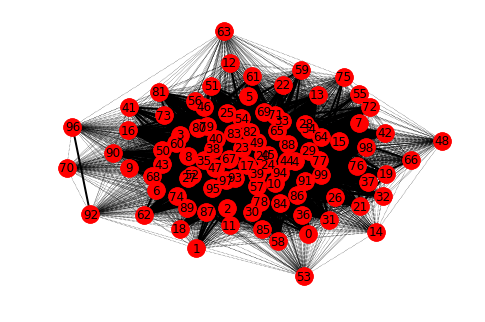

In [32]:
wMedian = np.median([d['weight'] for n1, n2, d in gDoc.edges(data = True)])
edgesHigh = [(n1, n2) for n1, n2, d in gDoc.edges(data = True) if d['weight'] > wMedian]
edgesLow = [(n1, n2) for n1, n2, d in gDoc.edges(data = True) if d['weight'] <= wMedian]
nx.draw(gDoc, pos = layout, labels = {n:n for n in gDoc.nodes()}, edgelist = edgesLow, style='dotted', width=.5)
nx.draw(gDoc, pos = layout, nodelist=None, edgelist = edgesHigh, width=2)

Now we can see why 53 and 63 are on the outside, while 39 and 23 are at the center. We can look at them:

In [33]:
print(len(senReleasesDF.iloc[63]['text']),"words:","\n",senReleasesDF.iloc[63]['text'].strip().replace('  ', '\n'))

314 words: 
 FOR IMMEDIATE RELEASE

Senator Kennedy issued the following statement this evening following Senator Kerrys apology

John Kerry s statement says it all
I wish the Bush administration brought as much energy and focus to trying to correct their mistakes in Iraq as it did in going after John Kerry


In [34]:
print(len(senReleasesDF.iloc[23]['text']),"words:","\n",senReleasesDF.iloc[23]['text'].strip().replace('  ', '\n'))

20603 words: 
 FOR IMMEDIATE RELEASE
REID

 We re sorry that we re starting a little bit late
but the House has some votes going
and so Leader Pelosi will be here and Congresswoman Solis real soon

 I m reminded of the story I learned as a little boy
When the kid was watching the sheep and he was supposed to yell
Wolf
when the wolf was coming
And he yelled
Wolf
as we know

Wolf
Wolf
and there was never any wolf
And finally when a wolf showed up
no one came

 And no matter how hard we try to be bipartisan here in Washington
with President Bush it s the proverbial cry for wolf

 As I said leaving the chamber last night
whatever he says
it s just the opposite

 And we re here today to talk about health care
But the cry of wolf is once again ringing in my ears because he keeps talking about how he wants to improve health care and we re now five years into this and there s been no improvement

 In fact
I hope the president mentions when he s in Tennessee today that there s almost a million 

Ah...those documents with the **most** words are unsprisingly the most central in this simple document network.

Now let's turn it around and look at the word-to-word network by documents. 

In [35]:
gWord = contractNetwork(g_2mode, 'word')
print(nx.info(gWord))

Name: 
Type: Graph
Number of nodes: 4270
Number of edges: 2080405
Average degree: 974.4286


First, let's reduce the number of words to a manageable size.

In [36]:
wMean = np.mean([d['weight'] for n1, n2, d in gWord.edges(data = True)])
wMean

1.9883402510568855

We are going to return to the sentence cooccurence graph, as it suggests many more meaningful (more local) associations. But without filtering, it is too large. Let's first drop all the edges with weight below 1250, then drop all the isolates:

In [37]:
g.remove_edges_from([(n1, n2) for n1, n2, d in g.edges(data = True) if d['weight'] <= 1250])
g.remove_nodes_from(list(nx.isolates(g))) #since we are changing the graph list() evaluates the isolates first
giant = max(nx.connected_component_subgraphs(g), key=len) # keep just the giant connected component
print(nx.info(giant))

Name: 
Type: Graph
Number of nodes: 166
Number of edges: 496
Average degree:   5.9759


A bit smaller now, Now, let's visualize it: 

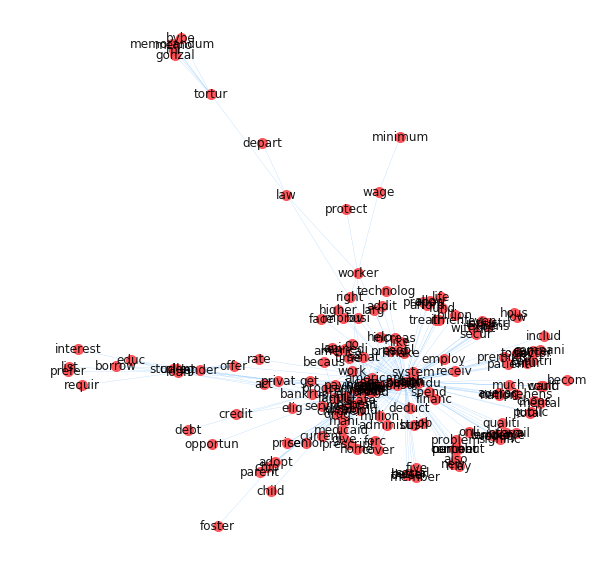

In [38]:
layout = nx.spring_layout(giant, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = "xkcd:light red",
        edge_color='xkcd:sky blue') #Getting labels is a bit annoying

We can also remove those words that show up in many documents...those with many connections (note that this has a similar effect to selecting those with a high tf.idf score):

In [39]:
giant.remove_nodes_from([n for n in giant.nodes if len(set(giant.neighbors(n))) >= 2000]) 
giant.remove_nodes_from(list(nx.isolates(giant)))
print(nx.info(giant))

Name: 
Type: Graph
Number of nodes: 166
Number of edges: 496
Average degree:   5.9759


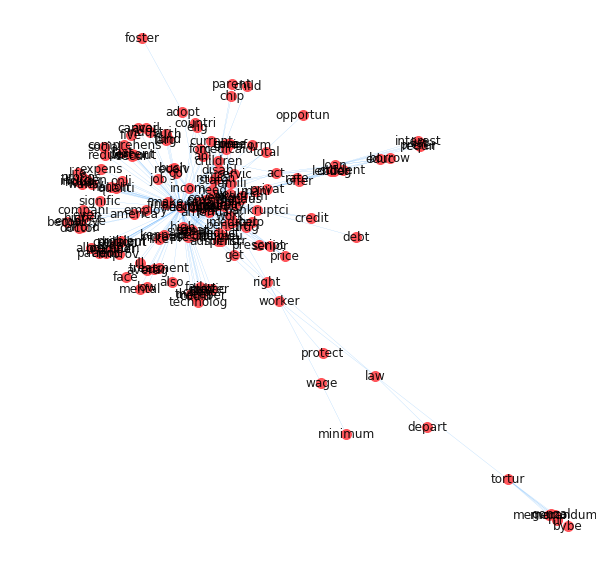

In [40]:
layout = nx.spring_layout(giant, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = "xkcd:light red",
        edge_color='xkcd:sky blue') #Getting labels is a bit annoying

We can continue to trim globally to investigate the structure of words at alternative slices of network density. 

Moreover, we can find cliques, or completely connected sets of nodes. 

In [41]:
nx.clique.number_of_cliques(giant)['presid']

2

In [42]:
print(', '.join(max(nx.clique.find_cliques(giant), key = lambda x: len(x))))

health, care, cost, plan, year, insur, save, provid, american, uninsur, account


Now lets look at a subgraph of the network, those nodes that are within 1 or 2 network steps of 'america'. 

In [43]:
americanNeighbors = giant.neighbors('american')
g_american = giant.subgraph(americanNeighbors)
print(nx.info(g_american))

Name: 
Type: SubGraph
Number of nodes: 22
Number of edges: 154
Average degree:  14.0000


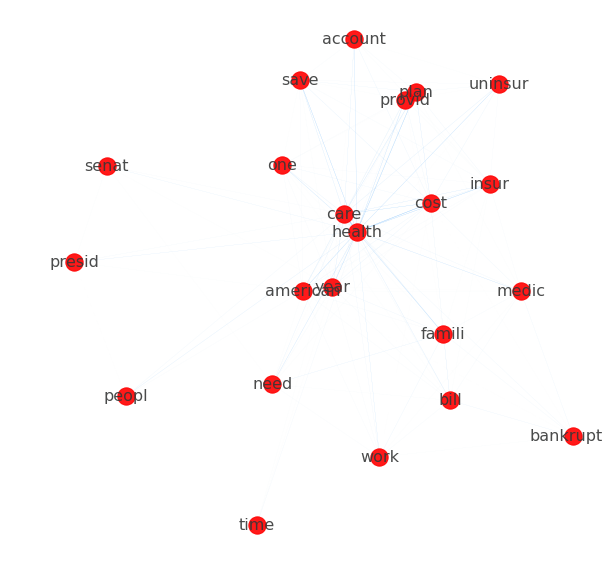

In [44]:
layout_amer = nx.spring_layout(g_american, weight='weight', iterations= 100, k = .3)
fig, ax = plt.subplots(figsize = (10,10))
maxWeight = max((d['weight'] for n1, n2, d in g_american.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in g_american.edges(data = True)))
nx.draw(g_american, ax = ax, pos = layout_amer, labels = {n:n for n in g_american.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in g_american.edges(data = True)], 
        alpha = .9, 
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:sky blue',
        cmap = plt.get_cmap('plasma')) 

In [45]:
americanNeighbors = gWord.neighbors('american')
americanNeighborsPlus1 = set(americanNeighbors)
for n in americanNeighbors:
    americanNeighborsPlus1 |= set(giant.neighbors(n))
    
#for x in americanNeighborsPlus1:
#    print(x)

In [46]:
g_american2 = giant.subgraph(americanNeighborsPlus1)
print(nx.info(g_american2))

Name: 
Type: SubGraph
Number of nodes: 165
Number of edges: 474
Average degree:   5.7455


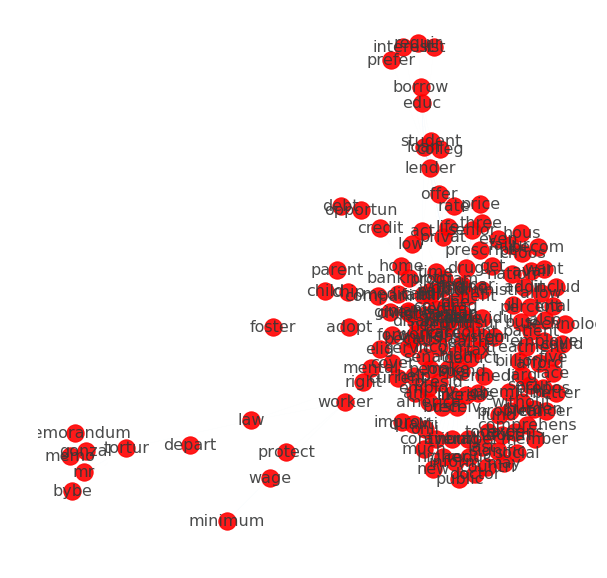

In [47]:
layout_amer = nx.spring_layout(g_american2, weight='weight', iterations= 100, k = .3)
fig, ax = plt.subplots(figsize = (10,10))
centralities_amer = nx.eigenvector_centrality(g_american2)
maxC = max(centralities_amer.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in g_american2.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in g_american2.edges(data = True)))
nx.draw(g_american2, ax = ax, pos = layout_amer, labels = {n:n for n in g_american2.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in g_american2.edges(data = True)], 
        alpha = .9, 
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:sky blue',
        cmap = plt.get_cmap('plasma')) 

## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Construct cells immediately below this that render some reasonable networks to meaningfully characterize the structure of words and documents (or subdocuments like chapters or paragraphs) from your corpus. What are useful filters and thresholds and what semantic structures do they reveal that given insight into the social world and social game inscribed in your corpus? Interrogate interesting subgraphs of your network and detail what they reveal about the semantic space involved.

In [48]:
#Working with an updated corpus, but have not been able to save
#Creation of new corpus below
import os
from os import listdir
from os.path import isfile, join
import re

In [49]:
targetDir = '/Users/Enya/Desktop/content-analysis-2018/Speeches'

In [58]:
def getText(x):
    reResults = re.findall(r'(TEXT:)(.*?)((END))', x.replace('\n', ' '), flags = re.M)
    return[t[1] for t in reResults]

def getDate(x) :
    reResults = re.findall(r'(DATE:)(.*?)(TITLE)', x.replace('\n', ' '))
    return[t[1] for t in reResults]

def getCategory(x):
    reResults = re.findall(r'(CATEGORY:)(.*?)(SPEECH)', x.replace('\n', ' '))
    return[t[1] for t in reResults]

def getTitle(x):
    reResults = re.findall(r'(TITLE:)(.*?)(TEXT)', x.replace('\n', ' '))
    return[t[1] for t in reResults]

In [59]:
speechestext = []
speechesdate = []
agency = []
title = []

for file in (file for file in os.scandir(targetDir) if file.is_file() and not file.name.startswith('.')):
    with open(file.path, encoding='utf-8') as f:
        workingText = f.read()
        workingText = str(workingText)
        goodText = getText(workingText)
        date = getDate(workingText)
        category = getCategory(workingText)
        speechtitle = getTitle(workingText)
        speechestext += goodText
        speechesdate += date
        agency += category
        title += speechtitle

speechesDF = pandas.DataFrame({'agency':agency, 'date' :speechesdate, 'title':title, 'text':speechestext})

In [60]:
speechesDF['tokenized-text'] = speechesDF['text'].apply(lambda x: nltk.word_tokenize(x))
speechesDF['tokenized-sents'] = speechesDF['text'].apply(lambda x: [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
speechesDF['normalized-sents'] = speechesDF['tokenized-sents'].apply(lambda x: [lucem_illud.normalizeTokens(s,stopwordLst = lucem_illud.stop_words_basic, stemmer = lucem_illud.stemmer_basic) for s in x])

In [61]:
speechesDF

agency                  date  \
0    DOS     December 01, 2016    
1    DOS     November 10, 2016    
2    DOS      October 10, 2016    
3    DOS      October 04, 2016    
4    DOS    September 28, 2016    
5    DOS    September 19, 2016    
6    DOS         June 03, 2016    
7    DOS          May 25, 2016    
8    DOS          May 25, 2016    
9    DOS        March 01, 2016    
10   DOS     February 26, 2016    
11   DOS     February 11, 2016    
12   DOS         July 29, 2015    
13   DOS          May 14, 2015    
14   DOS          May 04, 2015    
15   DOS     February 24, 2015    
16   DOS      January 13, 2015    
17   DOS        March 04, 2014    
18   DOS     December 03, 2013    
19   DOS      October 21, 2013    
20   DOS     November 26, 2012    
21   DOS      October 05, 2012    
22   DOS    September 18, 2012    
23   DOS       August 31, 2012    
24   DOS        March 07, 2012    
25   DOS     November 17, 2011    
26   DOS      October 31, 2011    
27   DOS      October 18, 2011    
28   DOS          May 18, 2011    
29   DOS          May 16, 2011    
30   DOS        March 23, 2010    
31   DOS    September 22, 2009    
32   DHS         June 22, 2016    
33   DHS     November 19, 2015    
34   DHS      October 06, 2015    
35   DHS        April 21, 2015    
36   DHS     February 12, 2014    
37   DHS         July 22, 2013    
38   DHS        April 16, 2012    
39   DHS      October 07, 2011    
40   DHS     December 17, 2010    
41   DHS      October 20, 2009    
42   DHS        August 4, 2009    

                                                 text  \
0    I would like to begin by thanking the UN Coun...   
1    Thank you to Saira for that kind introduction...   
2    Good morning! Thank you to Prime Minister Lee...   
3    Hello, My name is Chris Painter, and I am the...   
4    Introduction. Chairman Gardner, Ranking Membe...   
5    Chairman Donilon, Vice Chairman Palmisano, an...   
6    So what do zombies have to do with diplomacy?...   
7    MODERATOR: Thank you, and thanks to everyone ...   
8    Chairman Gardner, Ranking Member Cardin, memb...   
9    Good afternoon, and thank you for that warm w...   
10   Background: The Sixteenth Regular Session of ...   
11   Good afternoon. I’m looking forward to our di...   
12   Thank you for the opportunity to discuss deve...   
13   Chairman Gardner, Ranking Member Cardin, memb...   
14   Great. Well, thank you, and first of all good...   
15   ASSISTANT ATTORNEY GENERAL CALDWELL: Thank yo...   
16   Mr. Chairman, Ranking Member Engel, and Membe...   
17   It’s a pleasure to be here today. I want to b...   
18   MODERATOR: Good afternoon, and thank you all ...   
19   Good morning, Minister, Chairman Sasongko, Mr...   
20   MODERATOR: Good afternoon, everyone. The Fore...   
21   I am delighted to be able to send greetings t...   
22   Thank you, Colonel Brown, for your kind invit...   
23   Good Morning. Mr. Assistant Secretary General...   
24   I want to thank the Committee for the opportu...   
25   Thank you for your kind introduction. I am ho...   
26   MS. FULTON: All right. Thank you. And thanks ...   
27   MR. PAINTER: Thanks, and thanks for coming he...   
28   MODERATOR: Thank you, everyone, for coming to...   
29   Well, thank you very much. As you can guess f...   
30   Nina Fedoroff [Science and Technology Adviser...   
31   Andrew Reynolds: So, good morning ladies and ...   
32   This morning I realized that this summer mark...   
33   I begin with something about Paris. As the Pr...   
34   Good morning. Thank you very much Ann and tha...   
35   Thank you for inviting me to speak here today...   
36   Cybersecurity is one of the most important mi...   
37   Welcome, Minister Clare, Minister Collins, Se...   
38   Thank you for the introduction President Qayo...   
39   Thanks for the introduction. Good morning eve...   
40   Good morning. I'm happy to report it's snowin...   
41   Good morning, I’m Homeland Security Secretary...   
42   I want

In [62]:
def wordCooccurrence(sentences, makeMatrix = False):
    words = set()
    for sent in sentences:
        words |= set(sent)
    wordLst = list(words)
    wordIndices = {w: i for i, w in enumerate(wordLst)}
    wordCoCounts = {}
    #consider a sparse matrix if memory becomes an issue
    coOcMat = np.zeros((len(wordIndices), len(wordIndices)))
    for sent in sentences:
        for i, word1 in enumerate(sent):
            word1Index = wordIndices[word1]
            for word2 in sent[i + 1:]:
                coOcMat[word1Index][wordIndices[word2]] += 1
    if makeMatrix:
        return coOcMat, wordLst
    else:
        coOcMat = coOcMat.T + coOcMat
        g = nx.convert_matrix.from_numpy_matrix(coOcMat)
        g = nx.relabel_nodes(g, {i : w for i, w in enumerate(wordLst)})
        return g

In [108]:
g = wordCooccurrence(speechesDF['normalized-sents'].sum())

In [65]:
len(g.nodes)


3867

In [66]:
len(g.edges)

210851

In [67]:
nx.to_numpy_matrix(g)[:5, :5]

matrix([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

In [68]:
def tokenize(text):
    tokenlist = nltk.word_tokenize(text)
    normalized = lucem_illud.normalizeTokens(tokenlist, stopwordLst = lucem_illud.stop_words_basic, stemmer = lucem_illud.stemmer_basic)
    return normalized

In [69]:
speechesVectorizer = sklearn.feature_extraction.text.CountVectorizer(tokenizer = tokenize)
speechesVects_incidence = speechesVectorizer.fit_transform(speechesDF['text'])

In [70]:
speechesVects_incidence.shape

(43, 3867)

In [72]:
g_2mode = nx.Graph()

#define all the nodes
g_2mode.add_nodes_from((speechesVectorizer.get_feature_names()[i] for i in range(speechesVects_incidence.shape[1])), bipartite = 'word')
g_2mode.add_nodes_from(range(speechesVects_incidence.shape[0]), bipartite = 'doc')

#add all the edges
g_2mode.add_edges_from(((d, speechesVectorizer.get_feature_names()[w], {'weight' : speechesVects_incidence[d, w]}) for d, w in zip(*speechesVects_incidence.nonzero())))

In [73]:
print(nx.info(g_2mode))

Name: 
Type: Graph
Number of nodes: 3910
Number of edges: 19856
Average degree:  10.1565


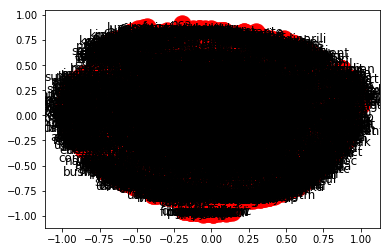

In [74]:
nx.draw_networkx(g_2mode)

In [75]:
def contractNetwork(g, targetType):
    g_mono = nx.Graph()
    g_mono.add_nodes_from(((n, d) for n, d in g_2mode.nodes(data = True) if d['bipartite'] == targetType))
    
    for n_outside in (n for n, d in g_2mode.nodes(data = True) if d['bipartite'] != targetType):
        neighbors = list((n for n in g.neighbors(n_outside) if g.nodes[n]['bipartite'] == targetType))
        for i, n1 in enumerate(neighbors):
            for n2 in neighbors[i+1:]:
                try:
                    g_mono.edges[n1, n2]['weight'] += 1
                except KeyError:
                    g_mono.add_edge(n1, n2, weight = 1)
    return g_mono

In [76]:
gDoc = contractNetwork(g_2mode, 'doc')

In [77]:
print(nx.info(gDoc))

Name: 
Type: Graph
Number of nodes: 43
Number of edges: 903
Average degree:  42.0000


In [78]:
layout = nx.spring_layout(gDoc, k = 1/3, weight='weight', iterations= 50)
nx.draw(gDoc, pos = layout, labels = {n:n for n in gDoc.nodes()}) #Getting labels is a bit annoying

In [79]:
wMedian = np.median([d['weight'] for n1, n2, d in gDoc.edges(data = True)])
edgesHigh = [(n1, n2) for n1, n2, d in gDoc.edges(data = True) if d['weight'] > wMedian]
edgesLow = [(n1, n2) for n1, n2, d in gDoc.edges(data = True) if d['weight'] <= wMedian]
nx.draw(gDoc, pos = layout, labels = {n:n for n in gDoc.nodes()}, edgelist = edgesLow, style='dotted', width=.5)
nx.draw(gDoc, pos = layout, nodelist=None, edgelist = edgesHigh, width=2)

In [80]:
print(len(speechesDF.iloc[21]['text']),"words:","\n",speechesDF.iloc[21]['text'].strip().replace('  ', '\n'))

1290 words: 
 I am delighted to be able to send greetings to all of you as you come together to tackle the full range of cyber policy issues. As I said last year when we launched our International Strategy for Cyberspace, the issues you’re working on represent a new foreign policy imperative for the United States. That’s why we are building
an environment in which norms of responsible behavior guide states’ actions, sustain partnerships, and support the rule of law in cyberspace. Within the last six months, the United States has launched new whole-of-government cyber dialogues with Brazil, India, South Africa, and many of our closest allies and like-minded partners. We have also had productive conversations with Russia and China, and we are working with key international and multilateral partners to find common ground; and we are supporting capacity building in the developing world by partnering with allies to deliver a range of programs. I am particularly pleased that you will be exam

In [81]:
print(len(speechesDF.iloc[6]['text']),"words:","\n",speechesDF.iloc[6]['text'].strip().replace('  ', '\n'))

12430 words: 
 So what do zombies have to do with diplomacy? Well, a few years ago some bad guys used tens of thousands of compromised or zombie computers located all over the world to launch an attack against a number of U.S. banks trying to knock them offline. Now, of course, we used technical means to try to respond, but we also used something new. We used diplomatic means. We contacted through diplomatic channels over 20 countries where these compromised computers were located and asked for their help. Now, asking other countries for help and trying to build a collective response to a common threat is at – it’s a common tool of diplomacy. And in this case, it turned out to be one of the most effective tools we have in mitigating the threat. Let me give you another example. Just a few months ago the leaders of the 20 largest economies got together and they agreed that international law applies in cyber space just like it does in the physical world. They also agreed that no country s

Similar to the hw, the documents with the most words are in the center

In [82]:
gWord = contractNetwork(g_2mode, 'word')
print(nx.info(gWord))

Name: 
Type: Graph
Number of nodes: 3867
Number of edges: 2598318
Average degree: 1343.8417


In [83]:
wMean = np.mean([d['weight'] for n1, n2, d in gWord.edges(data = True)])
wMean

2.1781921997230516

In [112]:
g = wordCooccurrence(speechesDF['normalized-sents'].sum())

In [113]:
g.remove_edges_from([(n1, n2) for n1, n2, d in g.edges(data = True) if d['weight'] <= 25])
g.remove_nodes_from(list(nx.isolates(g))) #since we are changing the graph list() evaluates the isolates first
giant = max(nx.connected_component_subgraphs(g), key=len) # keep just the giant connected component
print(nx.info(giant))

Name: 
Type: Graph
Number of nodes: 153
Number of edges: 473
Average degree:   6.1830


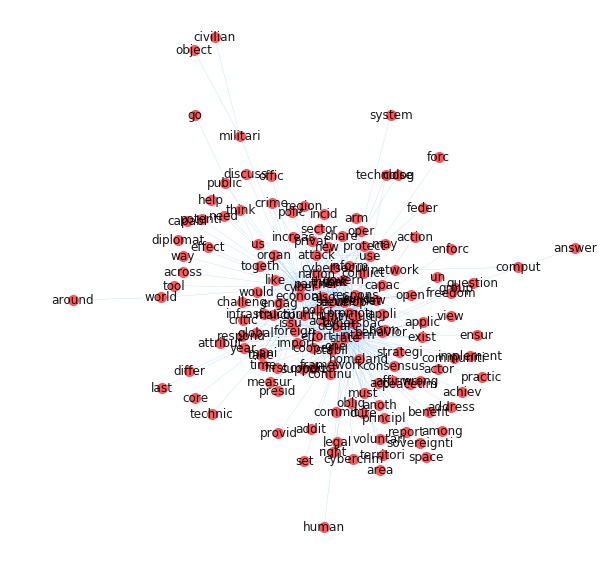

In [114]:
layout = nx.spring_layout(giant, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = "xkcd:light red",
        edge_color='xkcd:sky blue')

In [115]:
giant.remove_nodes_from([n for n in giant.nodes if len(set(giant.neighbors(n))) >= 2000]) 
giant.remove_nodes_from(list(nx.isolates(giant)))
print(nx.info(giant))


Name: 
Type: Graph
Number of nodes: 153
Number of edges: 473
Average degree:   6.1830


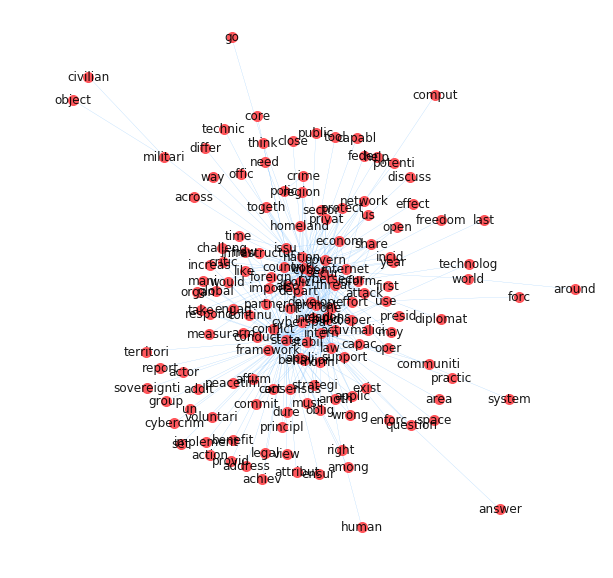

In [116]:
layout = nx.spring_layout(giant, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = "xkcd:light red",
        edge_color='xkcd:sky blue')

In [122]:
nx.clique.number_of_cliques(giant)['intern']

61

In [123]:
print(', '.join(max(nx.clique.find_cliques(giant), key = lambda x: len(x))))


state, cyber, intern, secur, law, cyberspac, promot, work, build


In [124]:
cyberNeighbors = giant.neighbors('cyber')
g_cyber = giant.subgraph(cyberNeighbors)
print(nx.info(g_cyber))

Name: 
Type: SubGraph
Number of nodes: 89
Number of edges: 368
Average degree:   8.2697


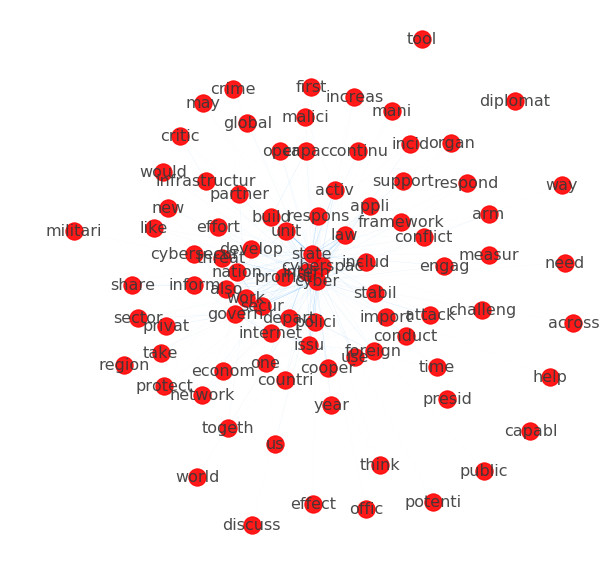

In [126]:
layout_cyber = nx.spring_layout(g_cyber, weight='weight', iterations= 100, k = .3)
fig, ax = plt.subplots(figsize = (10,10))
maxWeight = max((d['weight'] for n1, n2, d in g_cyber.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in g_cyber.edges(data = True)))
nx.draw(g_cyber, ax = ax, pos = layout_cyber, labels = {n:n for n in g_cyber.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in g_cyber.edges(data = True)], 
        alpha = .9, 
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:sky blue',
        cmap = plt.get_cmap('plasma'))

In [127]:
cyberNeighbors = gWord.neighbors('cyber')
cyberNeighborsPlus1 = set(cyberNeighbors)
for n in cyberNeighbors:
    cyberNeighborsPlus1 |= set(giant.neighbors(n))
    
for x in cyberNeighborsPlus1:
    print(x)

weekend
zealand
morocco
babi
count
mentor
engel
sequenc
cartel
qayoumi
sit
interf
tallinn
north
seem
dvds
syria
stagnant
music
antonio
carrier
immedi
improp
abl
free
refus
sponsorship
abus
past
whenev
crosscut
urban
israel
fight
telltal
lack
bill
fair
themselv
english
mention
bomb
communic
stole
schmidt
poland
login
isol
versa
safeguard
centric
pertin
indulg
insight
busi
accept
forward
unresolv
oh
legisl
window
eas
offend
thus
concept
sacrific
guid
mexico
cope
imag
hear
bank
soon
nicaragua
moreov
irrespons
retain
elit
son
rome
savag
dream
balkan
precondit
hacktivist
propaganda
upcom
presidenti
dial
underscor
primarili
especi
undertaken
byte
jeh
oecd
printer
domin
better
strongest
minimi
turn
task
steal
probe
reput
alert
termin
negat
war
advocaci
elect
situat
daylight
eventu
resourc
lynch
economi
heart
broadcast
recept
perpetu
acronym
ieee
forgot
dod
courtroom
treati
belong
remark
denuclear
price
unauthor
internship
dark
ever
landscap
ottawa
fast
breach
donilon
unwav
fraudul
ica
crypto


imposit
putin
chris
mandat
hygien
undersecretari
halt
ten
indic
interlocutor
mimic
keep
forcibl
caution
intergovernment
explos
complet
inconveni
abil
event
bunch
holder
misbehavior
utter
craig
ilea
ice
governmentwar
rule
earn
cultiv
sure
harden
donor
hardest
howard
revis
safeti
procur
holist
cyberact
outrag
methodolog
competit
oversight
hesit
chemic
geographi
front
phase
phish
ideolog
exercis
absolut
afoul
belgium
supplement
vibrant
ohio
expans
laid
convict
park
carri
tie
wake
unwant
guarante
victori
difficult
week
speed
basi
version
outlin
pacif
clock
visibl
particip
napolitano
prolif
interrog
knowledg
avenu
pool
hotel
doj
intend
full
among
accid
hijack
inflect
user
somehow
tax
butter
special
cell
firewal
malwar
uphold
incomplet
deepli
perimet
manner
histori
rogu
earli
summit
extent
univers
analyst
password
inclus
bad
grown
mispercept
sake
salvat
plain
lab
common
anybodi
begin
lotriont
mask
fix
none
signpost
cyberspac
wassenaar
purpos
standpoint
must
zip
hostag
hard
pronounc
mirror
at

implor
strike
tyrann
firearm
drug
illustr
disturb
relentless
manag
prison
contrast
headquart
readili
road
meltdown
struggl
pass
trust
multitud
interpret
gone
meaning
crude
traction
evalu
jim
emblem
comment
citi
bodi
theft
financi
alongsid
check
paul
stori
overlap
korean
clearest
varieti
parallel
smartphon
part
punctuat
outpour
crise
humankind
question
regulatori
barrier
escal
written
narrow
conscienti
spauld
crash
newli
govern
claim
happi
contest
collect
exceed
ctc
priorit
societi
troubl
dilig
podium
fif
firm
entir
overal
freez
hidden
issu
keith
lone
boalt
anoth
defin
singular
green
adopt
capit
actor
progress
map
lanka
command
upon
doctrin
ulaanbaatar
articul
main
entertain
digit
tens
isp
se
realign
amazon
anyway
anyon
headlin
github
deter
roll
authent
stronger
budapest
puzzl
tape
misattribut
factori
advantag
someth
open
lee
ramdin
daunt
highlight
endur
isra
reaction
shinzo
distribut
qualifi
examin
friend
multipli
tall
reader
elsewher
nsfnet
ethic
unus
dedic
aircraft
cathol
twice
deplo

In [128]:
g_cyber2 = giant.subgraph(cyberNeighborsPlus1)
print(nx.info(g_cyber2))

Name: 
Type: SubGraph
Number of nodes: 152
Number of edges: 384
Average degree:   5.0526


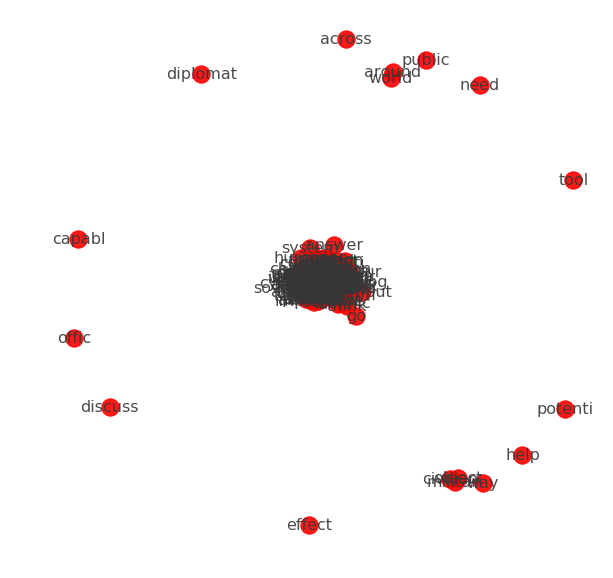

In [130]:
layout_cyber = nx.spring_layout(g_cyber2, weight='weight', iterations= 100, k = .3)
fig, ax = plt.subplots(figsize = (10,10))
centralities_cyber = nx.eigenvector_centrality(g_cyber2)
maxC = max(centralities_cyber.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in g_cyber2.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in g_cyber2.edges(data = True)))
nx.draw(g_cyber2, ax = ax, pos = layout_cyber, labels = {n:n for n in g_cyber2.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in g_cyber2.edges(data = True)], 
        alpha = .9, 
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:sky blue',
        cmap = plt.get_cmap('plasma'))

It appears that the world of "cyber" is mainly surrounded by strong action verbs. The second level suggests that there are additional actors involved, but they are more passive in their actions. Given that it is a smaller corpus, I found that the weight between nodes had to be signficantly reduced. Finally, the realm of cyber seems to be mostly linked to cybersecurity, states, international, and cyberspace.

# Network Statistics
We can often gain more insight into our semantic network through statistics that describe the positions of words within it.

We begin with measures of centrality. The concept of centrality is that some nodes (words or documents) are more *central* to the network than others. The most straightforward is the notion of degree centrality: those nodes that have the highest number of connections are the most central. Here our measure normalizes the number of connections by those with the most connections.

In [ ]:
dcentralities = nx.degree_centrality(giant)

In [ ]:
dcentralities['senat']

In [ ]:
max(dcentralities.items(), key = lambda x : x[1])

We can color and size the nodes by betweenness centrality, it's much faster to redraw since we aren't redoing the layout.

In [ ]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(dcentralities.items(), key = lambda x : x[1])[1]
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = [dcentralities[n] / maxC for n in giant.nodes],
        cmap = plt.get_cmap('plasma')) 

Another way to visualize the graph involes the use of size to represent degree centrality and edge weight:

In [ ]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(dcentralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gWord.edges(data = True)], 
        alpha = .9, 
        node_color = [dcentralities[n] / maxC for n in giant.nodes],
        node_size = [dcentralities[n] / maxC * 200 for n in giant.nodes],
        cmap = plt.get_cmap('plasma')) 

The distrubution of degree centrality is:

In [ ]:
plt.hist(list(dcentralities.values()))
plt.show()

What are the top and bottom ten words in terms of degree?

In [ ]:
sorted(dcentralities.items(), key = lambda x: x[1], reverse = True)[:10]

In [ ]:
sorted(dcentralities.items(), key = lambda x: x[1], reverse = True)[-10:]

Consider another very different measure, which is *betweenness* centrality. Betweenness centrality distinguishes nodes that require the most shortest pathways between all other nodes in the network. Semantically, words with a high betweenness centrality may link distinctive domains, rather than being "central" to any one. In other words, high *betweenness centrality* nodes may not have the highest *degree centrality*.

In [ ]:
centralities = nx.betweenness.betweenness_centrality(giant)

In [ ]:
centralities['senat']

In [ ]:
max(centralities.items(), key = lambda x : x[1])

We can color and size the nodes by betweenness centrality:

In [ ]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(centralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in giant.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities[n] / maxC for n in giant.nodes],
        node_size = [centralities[n] / maxC * 200 for n in giant.nodes],
        cmap = plt.get_cmap('plasma')) 

The distrubution of betweenness centrality is:

In [ ]:
plt.hist(list(centralities.values()))
plt.show()

This is an exponential distrubution, but you might need to add more nodes to see it clearly.

What are the top ten words in terms of betweenness?

In [ ]:
sorted(dcentralities.items(), key = lambda x: x[1], reverse = True)[:10]

What are words lower down?

In [ ]:
sorted(dcentralities.items(), key = lambda x: x[1], reverse = True)[50:60]

We can also look at closeness centrality, or the average Euclidean or path distance between a node and all others in the network. A node with the highest closeness centrality is most likely to send a signal with the most coverage to the rest of the network.

In [ ]:
centralities = nx.closeness_centrality(giant)

In [ ]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(centralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in giant.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities[n] / maxC for n in giant.nodes],
        node_size = [centralities[n] / maxC * 200 for n in giant.nodes],
        cmap = plt.get_cmap('plasma')) 

Top and bottom:

In [ ]:
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[:10]

In [ ]:
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[-10:]

Or eignvector centrality, an approach that weights degree by the centrality of those to whom one is tied (and the degree to whom they are tied, etc.) In short, its an $n$th order degree measure.

In [ ]:
centralities = nx.eigenvector_centrality(giant)

In [ ]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(centralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in giant.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities[n] / maxC for n in giant.nodes],
        node_size = [centralities[n] / maxC * 200 for n in giant.nodes],
        cmap = plt.get_cmap('plasma')) 

Note how the colors reveal a much more graduate distribution here. Let's look at it directly.

In [ ]:
plt.hist(list(centralities.values()))
plt.show()

Top and bottom:

In [ ]:
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[:10]

In [ ]:
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[-10:]

We can now filter our network by a centrality measure. Let's define a function and experiment with it:

In [ ]:
def filterWords(G, minWeight = 3, filter_ = "betweenness", rule = "number", value_of_rule = 200):
    """Function to filter network by degree centrality measures"""
    G = G.copy()
    try:
        G.remove_edges_from([(n1,n2) for n1, n2, d in G.edges(data = True) if d['weight'] < minWeight])
    except:
        print("weight might be missing from one or more edges")
        raise
    if filter_ =="betweenness":
        index = nx.betweenness_centrality(G) #betweeness centrality score
    elif filter_ == "closeness":
        index = nx.closeness_centrality(G) #closeness centrality score
    elif filter_ == "eigenvector":
        index = nx.eigenvector_centrality(G) #eigenvector centrality score
    elif filter_ == "degree":
        index = nx.degree_centrality(G) #degree centrality score
    else:
        raise ValueError("wrong filter paremeter, should be: betweenness/closeness/eigenvector")    
        
    if rule=='number':# if filter by limiting the total number of nodes 
        
        sorted_index = sorted(index.items(), key=lambda x:x[1], reverse=True)
        value_of_rule = np.min([value_of_rule, len(G.nodes)])
        
        nodes_remain = {}
        for word, centr in sorted_index[:value_of_rule]:
            nodes_remain[word] = centr
        G.remove_nodes_from([n for n in index if n not in nodes_remain])
        print ("Total number of nodes(after filtering) in the graph is %s" % len(G))
        return G
    
    if rule=='above':# if filter by limiting the min value of centrality
        value_of_rule = np.max([float(value_of_rule),0])
        G.remove_nodes_from([n for n in index if index[n] >=value_of_rule])
        print ("Total number of nodes(after filtering) in the graph is %s" % len(G))
        return G
    
    if rule=='below':# if filter by limiting the max value of centrality
        value_of_rule = np.max([float(value_of_rule),0])
        G.remove_nodes_from([n for n in index if index[n] <=value_of_rule])
        print ("Total number of nodes(after filtering) in the graph is %s" % len(G))
        return G

In [ ]:
giant_filtered30 = filterWords(giant, minWeight=3, filter_='betweenness', rule='number', value_of_rule=25)
print(nx.info(giant_filtered30))

In [ ]:
layout_giant_filtered30 = nx.spring_layout(giant_filtered30, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_giant30 = nx.betweenness_centrality(giant_filtered30)
maxC = max(centralities_giant30.items(), key = lambda x : x[1])[1]
nx.draw(giant_filtered30, ax = ax, pos = layout_giant_filtered30, labels = {n: n for n in giant_filtered30.nodes()},
        alpha = .9, 
        width = .5,
        node_color = [centralities_giant30[n] / maxC for n in giant_filtered30.nodes],
        node_size = [centralities_giant30[n] / maxC * 100 for n in giant_filtered30.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )

We can also look at global statistics, like the density of a network, defined as the number of actual edges divided by the total number of possible edges:

In [ ]:
nx.density(giant)

We can also calculate the average degree per node:

In [ ]:
np.mean([v for w,v in nx.degree(giant)])

The diameter calculates the average distance between any two nodes in the network:

In [ ]:
nx.diameter(giant)

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">Construct cells immediately below this that calculate different kinds of centrality for distinct words or documents in a network composed from your corpus of interest. Which type of words tend to be most and least central? Can you identify how different centrality measures distinguish different kind of words in your corpus? What do these patterns suggest about the semantic content and structure of your documents? Finally, calculate global measure for your network(s) and discuss what they reveal.

In [131]:
dcentralities = nx.degree_centrality(giant)

In [132]:
dcentralities['cyber']

0.5921052631578947

In [133]:
max(dcentralities.items(), key = lambda x : x[1])

('state', 0.6644736842105263)

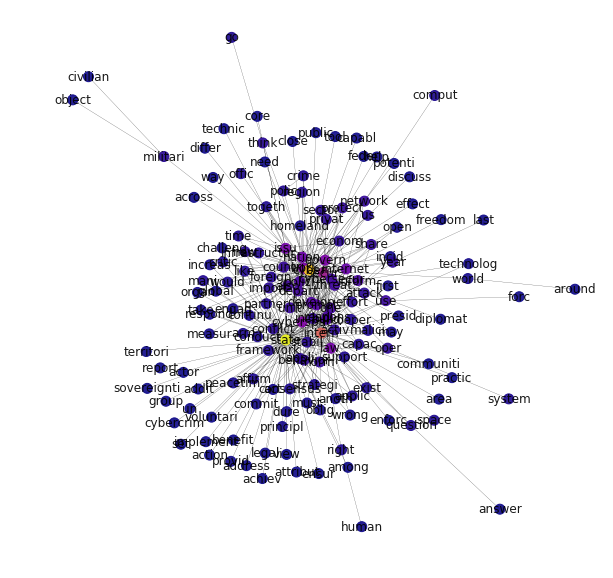

In [134]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(dcentralities.items(), key = lambda x : x[1])[1]
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = [dcentralities[n] / maxC for n in giant.nodes],
        cmap = plt.get_cmap('plasma'))

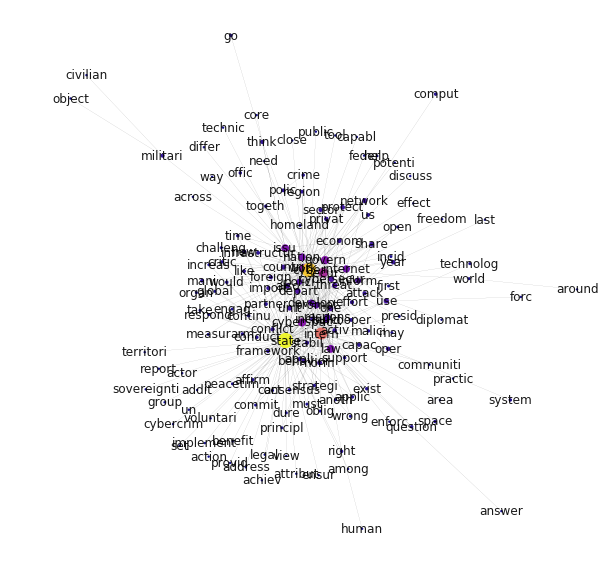

In [135]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(dcentralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gWord.edges(data = True)], 
        alpha = .9, 
        node_color = [dcentralities[n] / maxC for n in giant.nodes],
        node_size = [dcentralities[n] / maxC * 200 for n in giant.nodes],
        cmap = plt.get_cmap('plasma'))

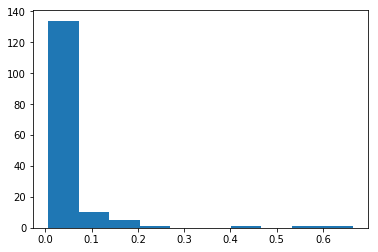

In [136]:
plt.hist(list(dcentralities.values()))
plt.show()

In [137]:
sorted(dcentralities.items(), key = lambda x: x[1], reverse = True)[:10]

[('state', 0.6644736842105263),
 ('cyber', 0.5921052631578947),
 ('intern', 0.40789473684210525),
 ('secur', 0.25),
 ('cyberspac', 0.17763157894736842),
 ('govern', 0.17105263157894735),
 ('work', 0.1644736842105263),
 ('issu', 0.1513157894736842),
 ('law', 0.1513157894736842),
 ('nation', 0.1381578947368421)]

In [138]:
sorted(dcentralities.items(), key = lambda x: x[1], reverse = True)[-10:]


[('benefit', 0.006578947368421052),
 ('group', 0.006578947368421052),
 ('object', 0.006578947368421052),
 ('diplomat', 0.006578947368421052),
 ('legal', 0.006578947368421052),
 ('way', 0.006578947368421052),
 ('human', 0.006578947368421052),
 ('territori', 0.006578947368421052),
 ('ensur', 0.006578947368421052),
 ('capabl', 0.006578947368421052)]

One of the focuses in my research is on the development of cyberspace being conceptualized in relation to territory, as such, I find it particularly interesting that cyberspac is central, while territori is not. This may suggest that they continue to be distant in discourse.

In [139]:
centralities = nx.betweenness.betweenness_centrality(giant)

In [140]:
centralities['cyber']

0.39531804486201344

In [141]:
max(centralities.items(), key = lambda x : x[1])


('state', 0.4467820000602376)

In [142]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(centralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in giant.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities[n] / maxC for n in giant.nodes],
        node_size = [centralities[n] / maxC * 200 for n in giant.nodes],
        cmap = plt.get_cmap('plasma'))

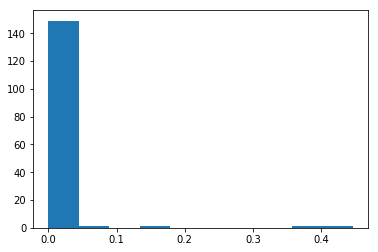

In [143]:
plt.hist(list(centralities.values()))
plt.show()

In [145]:
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[:10]

[('state', 0.4467820000602376),
 ('cyber', 0.39531804486201344),
 ('intern', 0.14820846344426447),
 ('issu', 0.04856329502765544),
 ('secur', 0.03935065773761177),
 ('law', 0.029185376348196717),
 ('militari', 0.026228651097943534),
 ('govern', 0.023667644175660897),
 ('internet', 0.02331301044313098),
 ('work', 0.023224019885014945)]

In [150]:
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[30:40]

[('promot', 0.0005535047230760023),
 ('polici', 0.0003277151085620936),
 ('activ', 0.0002904612524689206),
 ('cybersecur', 0.0001653617286241894),
 ('includ', 0.000156537867848429),
 ('econom', 0.00010333379102985239),
 ('protect', 7.842453816660857e-05),
 ('infrastructur', 6.390147554316254e-05),
 ('like', 5.0830719182061106e-05),
 ('behavior', 4.9240098037588453e-05)]

An additional component of my research considers the securitization of  cyber more broadly. As such, I think it is worth noting that cybersecur[ity] is not a central part of this corpus, while cyber and secur[e/ity] are central, independently.

In [151]:
centralities = nx.closeness_centrality(giant)

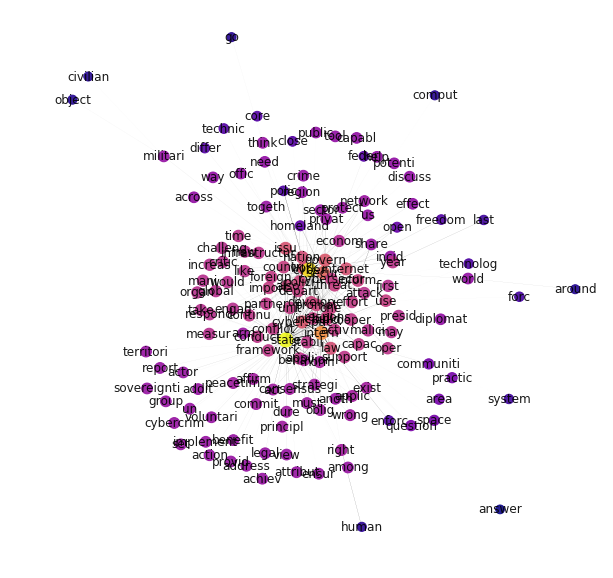

In [152]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(centralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in giant.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities[n] / maxC for n in giant.nodes],
        node_size = [centralities[n] / maxC * 200 for n in giant.nodes],
        cmap = plt.get_cmap('plasma'))

In [153]:
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[:10]


[('state', 0.7203791469194313),
 ('cyber', 0.6972477064220184),
 ('intern', 0.6055776892430279),
 ('secur', 0.5507246376811594),
 ('govern', 0.5241379310344828),
 ('cyberspac', 0.5223367697594502),
 ('work', 0.5205479452054794),
 ('issu', 0.5152542372881356),
 ('internet', 0.5135135135135135),
 ('law', 0.5100671140939598)]

In [154]:
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[-10:]


[('forc', 0.32688172043010755),
 ('system', 0.3206751054852321),
 ('last', 0.32),
 ('human', 0.30218687872763417),
 ('comput', 0.2980392156862745),
 ('go', 0.29571984435797666),
 ('civilian', 0.29457364341085274),
 ('object', 0.29457364341085274),
 ('around', 0.29343629343629346),
 ('answer', 0.2783882783882784)]

In [155]:
entralities = nx.eigenvector_centrality(giant)

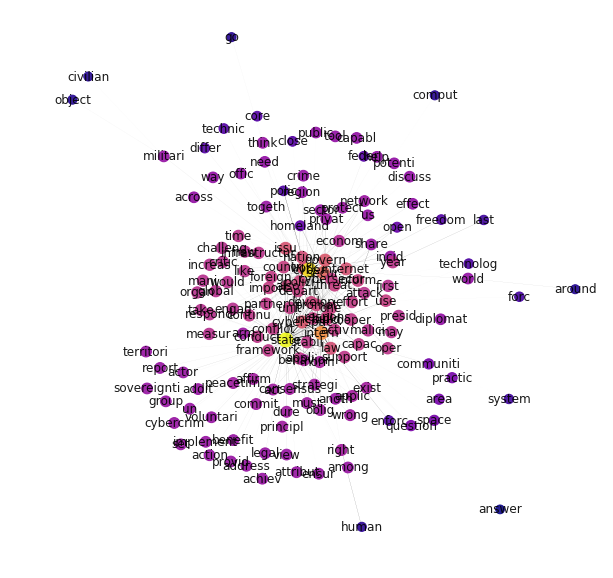

In [156]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(centralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in giant.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities[n] / maxC for n in giant.nodes],
        node_size = [centralities[n] / maxC * 200 for n in giant.nodes],
        cmap = plt.get_cmap('plasma'))

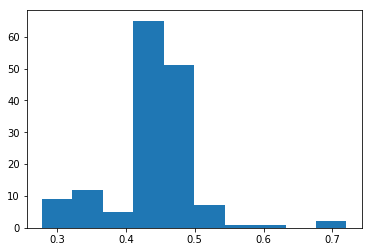

In [157]:
plt.hist(list(centralities.values()))
plt.show()

In [158]:
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[:10]


[('state', 0.7203791469194313),
 ('cyber', 0.6972477064220184),
 ('intern', 0.6055776892430279),
 ('secur', 0.5507246376811594),
 ('govern', 0.5241379310344828),
 ('cyberspac', 0.5223367697594502),
 ('work', 0.5205479452054794),
 ('issu', 0.5152542372881356),
 ('internet', 0.5135135135135135),
 ('law', 0.5100671140939598)]

In [159]:
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[-10:]


[('forc', 0.32688172043010755),
 ('system', 0.3206751054852321),
 ('last', 0.32),
 ('human', 0.30218687872763417),
 ('comput', 0.2980392156862745),
 ('go', 0.29571984435797666),
 ('civilian', 0.29457364341085274),
 ('object', 0.29457364341085274),
 ('around', 0.29343629343629346),
 ('answer', 0.2783882783882784)]

In [160]:
def filterWords(G, minWeight = 3, filter_ = "betweenness", rule = "number", value_of_rule = 200):
    """Function to filter network by degree centrality measures"""
    G = G.copy()
    try:
        G.remove_edges_from([(n1,n2) for n1, n2, d in G.edges(data = True) if d['weight'] < minWeight])
    except:
        print("weight might be missing from one or more edges")
        raise
    if filter_ =="betweenness":
        index = nx.betweenness_centrality(G) #betweeness centrality score
    elif filter_ == "closeness":
        index = nx.closeness_centrality(G) #closeness centrality score
    elif filter_ == "eigenvector":
        index = nx.eigenvector_centrality(G) #eigenvector centrality score
    elif filter_ == "degree":
        index = nx.degree_centrality(G) #degree centrality score
    else:
        raise ValueError("wrong filter paremeter, should be: betweenness/closeness/eigenvector")    
        
    if rule=='number':# if filter by limiting the total number of nodes 
        
        sorted_index = sorted(index.items(), key=lambda x:x[1], reverse=True)
        value_of_rule = np.min([value_of_rule, len(G.nodes)])
        
        nodes_remain = {}
        for word, centr in sorted_index[:value_of_rule]:
            nodes_remain[word] = centr
        G.remove_nodes_from([n for n in index if n not in nodes_remain])
        print ("Total number of nodes(after filtering) in the graph is %s" % len(G))
        return G
    
    if rule=='above':# if filter by limiting the min value of centrality
        value_of_rule = np.max([float(value_of_rule),0])
        G.remove_nodes_from([n for n in index if index[n] >=value_of_rule])
        print ("Total number of nodes(after filtering) in the graph is %s" % len(G))
        return G
    
    if rule=='below':# if filter by limiting the max value of centrality
        value_of_rule = np.max([float(value_of_rule),0])
        G.remove_nodes_from([n for n in index if index[n] <=value_of_rule])
        print ("Total number of nodes(after filtering) in the graph is %s" % len(G))
        return G

In [161]:
giant_filtered30 = filterWords(giant, minWeight=3, filter_='betweenness', rule='number', value_of_rule=25)
print(nx.info(giant_filtered30))

Total number of nodes(after filtering) in the graph is 25
Name: 
Type: Graph
Number of nodes: 25
Number of edges: 119
Average degree:   9.5200


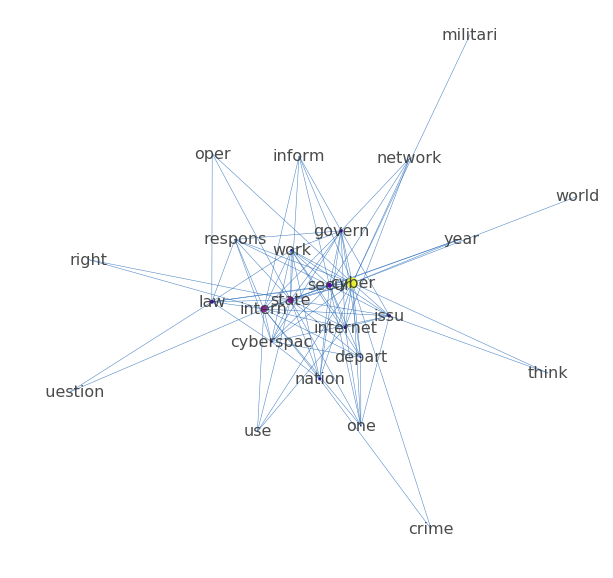

In [162]:
layout_giant_filtered30 = nx.spring_layout(giant_filtered30, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_giant30 = nx.betweenness_centrality(giant_filtered30)
maxC = max(centralities_giant30.items(), key = lambda x : x[1])[1]
nx.draw(giant_filtered30, ax = ax, pos = layout_giant_filtered30, labels = {n: n for n in giant_filtered30.nodes()},
        alpha = .9, 
        width = .5,
        node_color = [centralities_giant30[n] / maxC for n in giant_filtered30.nodes],
        node_size = [centralities_giant30[n] / maxC * 100 for n in giant_filtered30.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )

In [163]:
nx.density(giant)

0.04067767457860337

In [164]:
np.mean([v for w,v in nx.degree(giant)])

6.183006535947713

In [165]:
nx.diameter(giant)

5

Overall, all of the centrality measures find similar words to be the most central, but they offer different words as the least central. I found it interesting that some measures offered words that were more related to the central words than others. For instance, the closeness centrality measure was more oriented towards humans/people in its list of least central, compared to the other measures. Additional comments were made throughout the code. 
As for the global measure of my network, it does not appear to be particularly dense. However, I think that the diameter suggests that the words in the corpus continue to be interlinked within 5 degrees of removal. This isn't particularly surprising given that all the documents I am analyzing are speeches made by governemnt officials that focus on cybersecurity. 

# POS based networks

Now let's look at links between specific parts of speech within a network.

For this we will be using the `nltk` POS facilities instead of the Stanford ones. These are much faster, but also somewhat less accurate. (You get what you *pay* for in computational power).

Let's look at nouns co-occurring in sentences using the top 10 (by score) reddit posts on thread topics we have explored in prior sessions:

In [ ]:
redditDF = pandas.read_csv('../data/reddit.csv', index_col = 0)

In [ ]:
redditTopScores = redditDF.sort_values('score')[-100:]
redditTopScores['sentences'] = redditTopScores['text'].apply(lambda x: [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
redditTopScores.index = range(len(redditTopScores) - 1, -1,-1) #Reindex to make things nice in the future
redditTopScores[:3]

Now we'll normalize the tokens through stemming:

In [ ]:
redditTopScores['normalized_sents'] = redditTopScores['sentences'].apply(lambda x: [lucem_illud.normalizeTokens(s, stopwordLst = None, stemmer = lucem_illud.stemmer_basic) for s in x])

In [ ]:
def posCooccurrence(sentences, *posType, makeMatrix = False):
    words = set()
    reducedSents = []
    #Only using the first kind of POS for each word
    wordsMap = {}
    for sent in sentences:
        s = [(w, t) for w, t in nltk.pos_tag(sent) if t in posType]
        for w, t in s:
            if w not in wordsMap:
                wordsMap[w] = t
        reducedSent = [w for w, t in s]
        words |= set(reducedSent)
        reducedSents.append(reducedSent)
    wordLst = list(words)
    wordIndices = {w: i for i, w in enumerate(wordLst)}
    wordCoCounts = {}
    #consider a sparse matrix if memory becomes an issue
    coOcMat = np.zeros((len(wordIndices), len(wordIndices)))
    for sent in reducedSents:
        for i, word1 in enumerate(sent):
            word1Index = wordIndices[word1]
            for word2 in sent[i + 1:]:
                coOcMat[word1Index][wordIndices[word2]] += 1
    if makeMatrix:
        return coOcMat, wordLst
    else:
        coOcMat = coOcMat.T + coOcMat
        g = nx.convert_matrix.from_numpy_matrix(coOcMat)
        g = nx.relabel_nodes(g, {i : w for i, w in enumerate(wordLst)})
        for w in g.nodes:
            g.nodes[w]['bipartite'] = wordsMap[w]
        return g

In [ ]:
gNN = posCooccurrence(redditTopScores['normalized_sents'].sum(), 'NN')

In [ ]:
print(nx.info(gNN))

This is a bit too large to effectively visualize, so let's remove the vertices with degree less than or equal to 100:

In [ ]:
gNN.remove_nodes_from([n for n in gNN.nodes if len(set(gNN.neighbors(n))) <= 100]) 
print(nx.info(gNN))

And low weight edges:

In [ ]:
gNN.remove_edges_from([(n1, n2) for n1, n2, d in gNN.edges(data = True) if d['weight'] <= 2])
print(nx.info(gNN))

In [ ]:
layout_nn = nx.spring_layout(gNN, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_nn = nx.eigenvector_centrality(gNN)
maxC = max(centralities_nn.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in gNN.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in gNN.edges(data = True)))
nx.draw(gNN, ax = ax, pos = layout_nn, labels = {n: n for n in gNN.nodes()},
        #width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gNN.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities_nn[n] / maxC for n in gNN.nodes],
        node_size = [centralities_nn[n] / maxC * 100 for n in gNN.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )

That is an interesting pattern; everyone is talking about themselves ("I...this", "I...that").

What if we want to look at noun-verb pairs instead?

In [ ]:
gNV = posCooccurrence(redditTopScores['normalized_sents'].sum(), 'NN', 'VB')

`gNV` has co-occurrences between nouns and nouns as well as between verbs and verbs. Let's remove these and make it purely about noun and verb combinations:

In [ ]:
print(nx.info(gNV))

In [ ]:
gNV.remove_edges_from([(n1,n2) for n1,n2,d in gNV.edges(data = True) if gNV.nodes[n1]['bipartite'] == gNV.nodes[n2]['bipartite']])

In [ ]:
print(nx.info(gNV))

Dropping low weight edges and low degree vertices gives us:

In [ ]:
gNV.remove_edges_from([(n1, n2) for n1, n2, d in gNV.edges(data = True) if d['weight'] <= 2])
gNV.remove_nodes_from([n for n in gNV.nodes if len(set(gNV.neighbors(n))) <= 5])

In [ ]:
print(nx.info(gNV))

In [ ]:
layout_nn = nx.spring_layout(gNV, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_nv = nx.eigenvector_centrality(gNV)
maxC = max(centralities_nv.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in gNV.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in gNV.edges(data = True)))
nx.draw(gNV, ax = ax, pos = layout_nn, labels = {n: n for n in gNV.nodes()},
        #width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gNN.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities_nv[n] / maxC for n in gNV.nodes],
        node_size = [centralities_nv[n] / maxC * 100 for n in gNV.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       ) 

Lets create an "ego network" surrounding a single (important) word, as we did before:

In [ ]:
g_i = gNV.subgraph(['i'] + list(gNV.neighbors('i')))

In [ ]:
print(nx.info(g_i))

In [ ]:
nx.draw_networkx(g_i)

Instead of just nodes connected to a vertex, we can find all those connected to it within 2 hops, lets look at 'stori' for this:

In [ ]:
storyNeighbors = gNV.neighbors('stori')
set(storyNeighbors)

In [ ]:
storyNeighbors = set(gNV.neighbors('stori'))
storyNeighborsPlus1 = set(storyNeighbors)
for n in storyNeighbors:
    storyNeighborsPlus1 |= set(gNV.neighbors(n))

In [ ]:
gNV_story = gNV.subgraph(storyNeighborsPlus1)
print(nx.info(gNV_story))

This is a mid-sized network, but we can interrogate it intelligently by computing some statistics. Degree centrality:

In [ ]:
sorted(nx.degree_centrality(gNV_story).items(), key = lambda x: x[1], reverse = True)[:10]

Or eigenvector centrality:

In [ ]:
sorted(nx.eigenvector_centrality(gNV_story).items(), key = lambda x: x[1], reverse = True)[:10]

Notice that 'stori' isn't even in the top 5:

Lets plot it:

In [ ]:
layout_story = nx.spring_layout(gNV_story, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(gNV_story, ax = ax, pos = layout_story, labels = {n: n for n in gNV_story.nodes()},
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
       ) 

"I" is still in the middle. These are stories about the self.

Lets create a noun-adjective network:

In [ ]:
gNJ = posCooccurrence(redditTopScores['normalized_sents'][:100].sum(), 'NN', 'JJ')
print(nx.info(gNJ))

By filtering by a centrality measure we can get a more 'central' set of nodes instead of just the most connected.

In [ ]:
gNJ_filtered200 = filterWords(gNJ, minWeight=3, filter_='betweenness', rule='number', value_of_rule=25)
print(nx.info(gNJ_filtered200))

In [ ]:
layout_NJ_filtered200 = nx.spring_layout(gNJ_filtered200, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_nj200 = nx.betweenness_centrality(gNJ_filtered200)
maxC = max(centralities_nj200.items(), key = lambda x : x[1])[1]
nx.draw(gNJ_filtered200, ax = ax, pos = layout_NJ_filtered200, labels = {n: n for n in gNJ_filtered200.nodes()},
        alpha = .9, 
        width = .5,
        node_color = [centralities_nj200[n] / maxC for n in gNJ_filtered200.nodes],
        node_size = [centralities_nj200[n] / maxC * 100 for n in gNJ_filtered200.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )

A truly self-centered network.

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">Construct cells immediately below this that construct at least two different networks comprising different combinations of word types, linked by different syntactic structures, which illuminate your corpus and the dynamics you are interested to explore. Graph these networks or subnetworks within them. What are relationships that are meaningful? 

<span style="color:red">***Stretch***: Graph some word-centered "ego-networks" with words one link away, two links away, and three links away (we only did up to two links away above).

In [166]:
def posCooccurrence(sentences, *posType, makeMatrix = False):
    words = set()
    reducedSents = []
    #Only using the first kind of POS for each word
    wordsMap = {}
    for sent in sentences:
        s = [(w, t) for w, t in nltk.pos_tag(sent) if t in posType]
        for w, t in s:
            if w not in wordsMap:
                wordsMap[w] = t
        reducedSent = [w for w, t in s]
        words |= set(reducedSent)
        reducedSents.append(reducedSent)
    wordLst = list(words)
    wordIndices = {w: i for i, w in enumerate(wordLst)}
    wordCoCounts = {}
    #consider a sparse matrix if memory becomes an issue
    coOcMat = np.zeros((len(wordIndices), len(wordIndices)))
    for sent in reducedSents:
        for i, word1 in enumerate(sent):
            word1Index = wordIndices[word1]
            for word2 in sent[i + 1:]:
                coOcMat[word1Index][wordIndices[word2]] += 1
    if makeMatrix:
        return coOcMat, wordLst
    else:
        coOcMat = coOcMat.T + coOcMat
        g = nx.convert_matrix.from_numpy_matrix(coOcMat)
        g = nx.relabel_nodes(g, {i : w for i, w in enumerate(wordLst)})
        for w in g.nodes:
            g.nodes[w]['bipartite'] = wordsMap[w]
        return g

In [176]:
gNN = posCooccurrence(speechesDF['normalized-sents'].sum(), 'NN')

In [168]:
print(nx.info(gNN))

Name: 
Type: Graph
Number of nodes: 2870
Number of edges: 80579
Average degree:  56.1526


In [177]:
gNN.remove_nodes_from([n for n in gNN.nodes if len(set(gNN.neighbors(n))) <= 500]) 
print(nx.info(gNN))

Name: 
Type: Graph
Number of nodes: 30
Number of edges: 462
Average degree:  30.8000


In [178]:
gNN.remove_edges_from([(n1, n2) for n1, n2, d in gNN.edges(data = True) if d['weight'] <= 3])
print(nx.info(gNN))

Name: 
Type: Graph
Number of nodes: 30
Number of edges: 432
Average degree:  28.8000


In [179]:
layout_nn = nx.spring_layout(gNN, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_nn = nx.eigenvector_centrality(gNN)
maxC = max(centralities_nn.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in gNN.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in gNN.edges(data = True)))
nx.draw(gNN, ax = ax, pos = layout_nn, labels = {n: n for n in gNN.nodes()},
        #width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gNN.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities_nn[n] / maxC for n in gNN.nodes],
        node_size = [centralities_nn[n] / maxC * 100 for n in gNN.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )

I tried diffrent variables above until I got this graph which was legible 

In [180]:
gNV = posCooccurrence(speechesDF['normalized-sents'].sum(), 'NN', 'VB')


In [181]:
print(nx.info(gNV))

Name: 
Type: Graph
Number of nodes: 2948
Number of edges: 88201
Average degree:  59.8379


In [182]:
gNV.remove_edges_from([(n1,n2) for n1,n2,d in gNV.edges(data = True) if gNV.nodes[n1]['bipartite'] == gNV.nodes[n2]['bipartite']])

In [183]:
print(nx.info(gNV))

Name: 
Type: Graph
Number of nodes: 2948
Number of edges: 8470
Average degree:   5.7463


In [184]:
gNV.remove_edges_from([(n1, n2) for n1, n2, d in gNV.edges(data = True) if d['weight'] <= 2])
gNV.remove_nodes_from([n for n in gNV.nodes if len(set(gNV.neighbors(n))) <= 5])

In [185]:
print(nx.info(gNV))

Name: 
Type: Graph
Number of nodes: 74
Number of edges: 403
Average degree:  10.8919


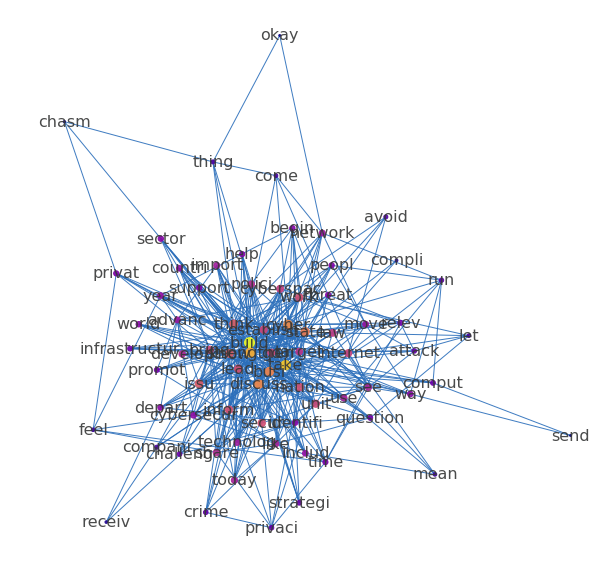

In [186]:
layout_nn = nx.spring_layout(gNV, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_nv = nx.eigenvector_centrality(gNV)
maxC = max(centralities_nv.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in gNV.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in gNV.edges(data = True)))
nx.draw(gNV, ax = ax, pos = layout_nn, labels = {n: n for n in gNV.nodes()},
        #width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gNN.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities_nv[n] / maxC for n in gNV.nodes],
        node_size = [centralities_nv[n] / maxC * 100 for n in gNV.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )

In [190]:
g_i = gNV.subgraph(['cyber'] + list(gNV.neighbors('cyber')))

In [191]:
print(nx.info(g_i))

Name: 
Type: SubGraph
Number of nodes: 23
Number of edges: 22
Average degree:   1.9130


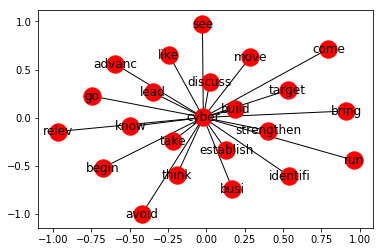

In [192]:
nx.draw_networkx(g_i)

In [194]:
cyberNeighbors = gNV.neighbors('cyber')
set(cyberNeighbors)

{'advanc',
 'avoid',
 'begin',
 'bring',
 'build',
 'busi',
 'come',
 'discuss',
 'establish',
 'go',
 'identifi',
 'know',
 'lead',
 'like',
 'move',
 'relev',
 'run',
 'see',
 'strengthen',
 'take',
 'target',
 'think'}

In [195]:
cyberNeighbors = set(gNV.neighbors('cyber'))
cyberNeighborsPlus1 = set(cyberNeighbors)
for n in cyberNeighbors:
    cyberNeighborsPlus1 |= set(gNV.neighbors(n))

In [196]:
gNV_cyber = gNV.subgraph(cyberNeighborsPlus1)
print(nx.info(gNV_cyber))

Name: 
Type: SubGraph
Number of nodes: 65
Number of edges: 370
Average degree:  11.3846


In [198]:
sorted(nx.degree_centrality(gNV_cyber).items(), key = lambda x: x[1], reverse = True)[:10]


[('build', 0.59375),
 ('take', 0.5),
 ('strengthen', 0.46875),
 ('discuss', 0.390625),
 ('busi', 0.390625),
 ('cyber', 0.34375),
 ('think', 0.34375),
 ('know', 0.328125),
 ('state', 0.296875),
 ('go', 0.296875)]

In [199]:
sorted(nx.eigenvector_centrality(gNV_cyber).items(), key = lambda x: x[1], reverse = True)[:10]


[('build', 0.2792794856792089),
 ('take', 0.24846362124852034),
 ('strengthen', 0.23077330239787802),
 ('cyber', 0.2066708827206563),
 ('discuss', 0.2025839618081588),
 ('busi', 0.1994832970794047),
 ('state', 0.18869825655951097),
 ('know', 0.16712891832635834),
 ('think', 0.1666021187883714),
 ('issu', 0.1650599788914723)]

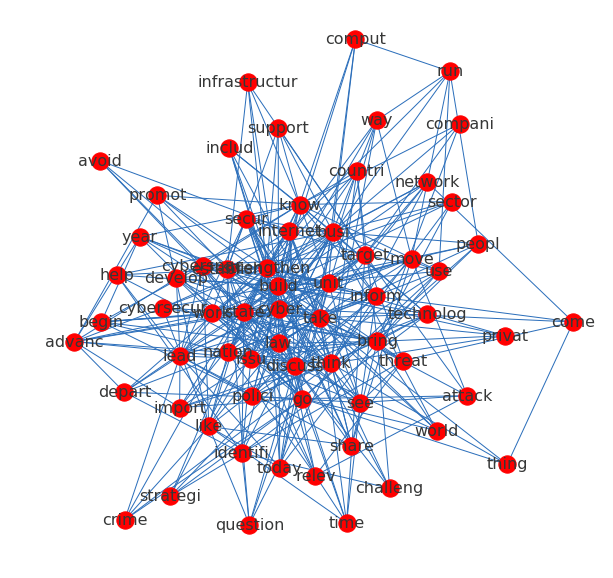

In [201]:
layout_cyber = nx.spring_layout(gNV_cyber, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(gNV_cyber, ax = ax, pos = layout_cyber, labels = {n: n for n in gNV_cyber.nodes()},
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
       )

Cyber continues to be in the middle. On the upper right hand side there seems to be a more business oriented narrative, in comparison to the center and other extremeties which focus on security, nations, and infrastructure. 

In [202]:
gNJ = posCooccurrence(speechesDF['normalized-sents'].sum(), 'NN', 'JJ')
print(nx.info(gNJ))

Name: 
Type: Graph
Number of nodes: 3421
Number of edges: 137924
Average degree:  80.6337


In [203]:
gNJ_filtered200 = filterWords(gNJ, minWeight=3, filter_='betweenness', rule='number', value_of_rule=25)
print(nx.info(gNJ_filtered200))

Total number of nodes(after filtering) in the graph is 25
Name: 
Type: Graph
Number of nodes: 25
Number of edges: 309
Average degree:  24.7200


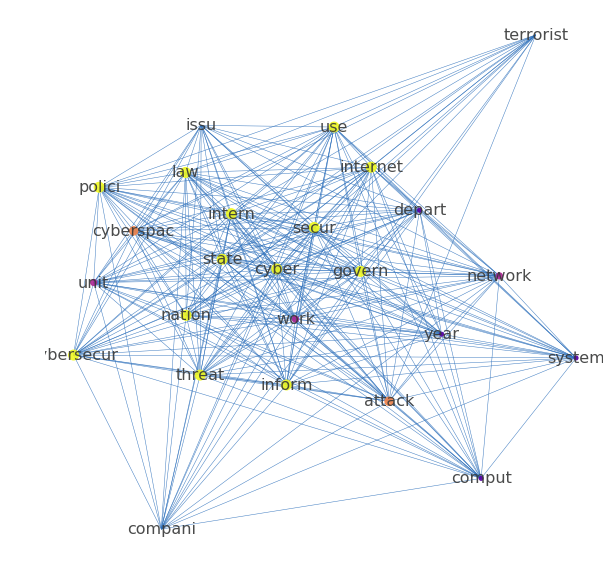

In [204]:
layout_NJ_filtered200 = nx.spring_layout(gNJ_filtered200, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_nj200 = nx.betweenness_centrality(gNJ_filtered200)
maxC = max(centralities_nj200.items(), key = lambda x : x[1])[1]
nx.draw(gNJ_filtered200, ax = ax, pos = layout_NJ_filtered200, labels = {n: n for n in gNJ_filtered200.nodes()},
        alpha = .9, 
        width = .5,
        node_color = [centralities_nj200[n] / maxC for n in gNJ_filtered200.nodes],
        node_size = [centralities_nj200[n] / maxC * 100 for n in gNJ_filtered200.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )

What stands out the most in this case is that terrorist is so far removed from the rest of the words (as well as companies, computer, and system). Given its relation to security, I would have assumed that terrorist would be more linked than it actually is. 

# Interactional influence

In a recent paper by Fangjian Guo, Charles Blundell, Hanna Wallach, and Katherine Heller entitled ["The Bayesian Echo Chamber: Modeling Social Influence via Linguistic Accommodation"](https://arxiv.org/pdf/1411.2674.pdf), the authors develop a method to estimate the influence of one speaker on another in order to estimate a kind of interpersonal influence network. Here we walk through this method, which relies on a kind of point process called a Hawkes process that estimate the influence of one point on another. Specifically, what they estimate is the degree to which one actor to an interpersonal interaction engaged in "accomodation" behaviors relative to the other, generating a directed edge from the one to the other.

### First let's look at the output of their analysis:

In [205]:
example_name = '12-angry-men'   #example datasets: "12-angry-men" or "USpresident"

In [206]:
result_path = '../data/Bayesian-echo/results/{}/'.format(example_name)
if not os.path.isdir(result_path):
    raise ValueError('Invalid example selected, only "12-angry-men" or "USpresident" are avaliable')

In [207]:
df_meta_info = pandas.read_table(result_path + 'meta-info.txt',header=None)
df_log_prob = pandas.read_csv(result_path + "SAMPLE-log_prior_and_log_likelihood.txt",delim_whitespace=True) #log_prob samples
df_influence = pandas.read_csv(result_path + 'SAMPLE-influence.txt',delim_whitespace=True) # influence samples
df_participants = pandas.read_csv(result_path + 'cast.txt', delim_whitespace=True)
person_id = pandas.Series(df_participants['agent.num'].values-1,index=df_participants['agent.name']).to_dict()
print()
print ('Person : ID')
person_id


Person : ID


{'Foreman': 3,
 'Juror 10': 2,
 'Juror 11': 6,
 'Juror 12': 7,
 'Juror 2': 9,
 'Juror 3': 1,
 'Juror 4': 5,
 'Juror 5': 11,
 'Juror 6': 8,
 'Juror 7': 4,
 'Juror 8': 0,
 'Juror 9': 10}

In [208]:
def getDensity(df):
    data = df#_log_prob['log.prior']
    density = scipy.stats.gaussian_kde(data)
    width = np.max(data) - np.min(data)
    xs = np.linspace(np.min(data)-width/5, np.max(data)+width/5,600)
    density.covariance_factor = lambda : .25
    density._compute_covariance()
    return xs, density(xs)

### Plot MCMC (Markov Monte Carlo) trace and the density of log-likelihoods

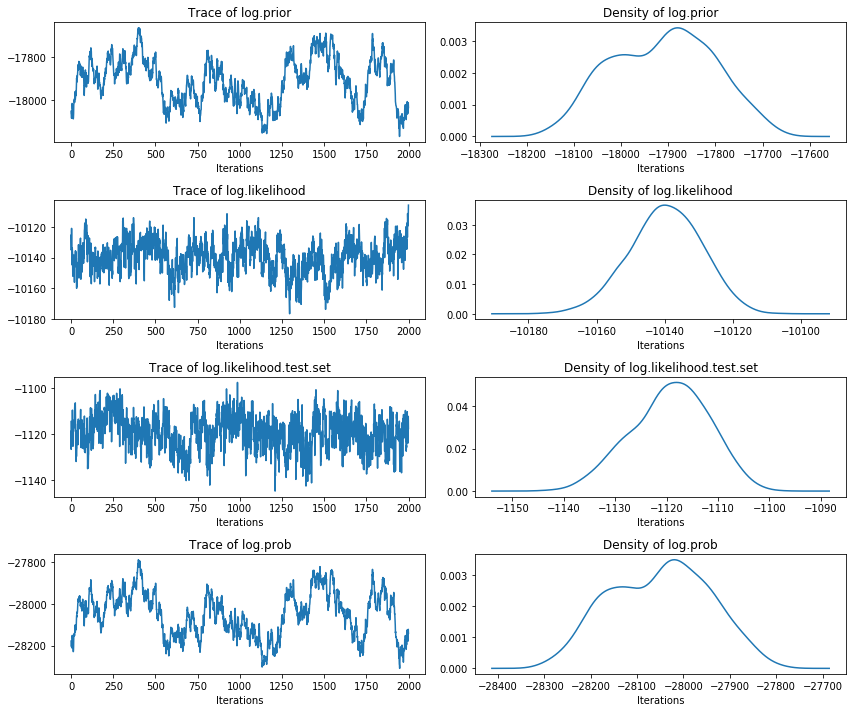

In [209]:
fig = plt.figure(figsize=[12,10])

plt.subplot(4,2,1)
plt.plot(df_log_prob['log.prior'])
plt.xlabel('Iterations')
plt.title('Trace of log.prior')

plt.subplot(4,2,2)
x,y = getDensity(df_log_prob['log.prior'])
plt.plot(x,y)
plt.xlabel('Iterations')
plt.title('Density of log.prior')

plt.subplot(4,2,3)
plt.plot(df_log_prob['log.likelihood'])
plt.title('Trace of log.likelihood')
plt.xlabel('Iterations')
plt.tight_layout()

plt.subplot(4,2,4)
x,y = getDensity(df_log_prob['log.likelihood'])
plt.plot(x,y)
plt.xlabel('Iterations')
plt.title('Density of log.likelihood')

plt.subplot(4,2,5)
plt.plot(df_log_prob['log.likelihood.test.set'])
plt.title('Trace of log.likelihood.test.set')
plt.xlabel('Iterations')
plt.tight_layout()

plt.subplot(4,2,6)
x,y = getDensity(df_log_prob['log.likelihood.test.set'])
plt.plot(x,y)
plt.xlabel('Iterations')
plt.title('Density of log.likelihood.test.set')

plt.subplot(4,2,7)
plt.plot(df_log_prob['log.prior']+df_log_prob['log.likelihood'])
plt.title('Trace of log.prob')
plt.xlabel('Iterations')

plt.subplot(4,2,8)
x,y = getDensity(df_log_prob['log.prior']+df_log_prob['log.likelihood'])
plt.plot(x,y)
plt.xlabel('Iterations')
plt.title('Density of log.prob')

plt.tight_layout()

plt.show()

### Plot the influence matrix between participants

In [210]:
A = int(np.sqrt(len(df_influence.columns))) #number of participants
id_person = {}
for p in person_id:
    id_person[person_id[p]]=p

In [211]:
def getmatrix(stacked,A):
    influence_matrix = [[0 for i in range(A)] for j in range(A)]
    for row in stacked.iteritems():
        from_ = int(row[0].split('.')[1])-1
        to_ = int(row[0].split('.')[2])-1
        value = float(row[1])
        influence_matrix[from_][to_]=value
    df_ = pandas.DataFrame(influence_matrix) 
    
    df_ =df_.rename(index = id_person)
    df_ =df_.rename(columns = id_person)
    return df_

In [212]:
stacked = df_influence.mean(axis=0)
df_mean = getmatrix(stacked,A)

stacked = df_influence.std(axis=0)
df_std = getmatrix(stacked,A)

In [213]:
df_mean

Juror 8   Juror 3  Juror 10   Foreman   Juror 7   Juror 4  \
Juror 8   0.000000  3.757957  8.089079  0.930180  5.167497  0.794645   
Juror 3   8.529312  0.000000  6.673916  4.150076  2.534751  4.902852   
Juror 10  8.413188  7.427932  0.000000  4.540236  3.216307  1.030049   
Foreman   1.137060  0.612615  1.945196  0.000000  1.521390  0.834870   
Juror 7   2.603853  5.901169  0.648844  1.969868  0.000000  1.110101   
Juror 4   5.791320  0.200669  0.266484  0.582956  0.094200  0.000000   
Juror 11  0.378515  0.544628  0.779340  0.454645  0.290575  0.447512   
Juror 12  5.961338  0.695831  0.519459  1.253033  0.247939  0.162463   
Juror 6   4.526244  0.923784  0.503503  1.049825  1.288920  0.451562   
Juror 2   0.583732  2.303417  0.529583  1.722894  2.005939  0.299311   
Juror 9   1.216641  1.281288  0.967587  1.675483  1.657341  1.681338   
Juror 5   0.552951  1.001575  0.696393  1.180245  1.180355  0.497265   

          Juror 11  Juror 12   Juror 6   Juror 2   Juror 9   Juror 5  
Juror 8   0.845335  1.336329  6.106684  0.916765  6.385205  7.300776  
Juror 3   1.092571  0.509942  3.825015  3.861767  0.266426  1.561626  
Juror 10  1.004598  0.529232  2.426582  0.407460  1.233599  0.885871  
Foreman   1.338554  3.230634  1.013511  3.534036  1.311436  4.115411  
Juror 7   0.279870  0.608548  1.047693  2.910670  1.619475  1.570038  
Juror 4   3.347982  0.316963  0.300770  2.112033  0.370973  0.673364  
Juror 11  0.000000  0.614536  0.821143  0.951222  0.476986  0.844157  
Juror 12  0.388620  0.000000  2.500976  2.375977  0.481394  0.834032  
Juror 6   0.375776  0.904313  0.000000  2.861587  0.905421  0.310822  
Juror 2   0.652302  1.623813  0.841376  0.000000  1.691612  1.756225  
Juror 9   0.623032  1.925996  1.907992  0.539666  0.000000  1.138934  
Juror 5   0.786181  0.588822  0.724613  0.912616  1.224854  0.000000

MEAN of influence matrix (row=from, col=to)


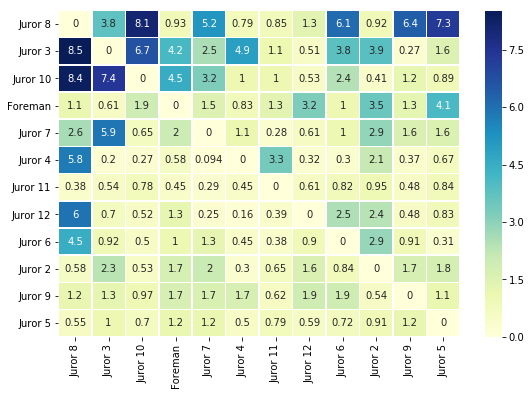

In [214]:
f, ax = plt.subplots(figsize=(9, 6))
seaborn.heatmap(df_mean, annot=True,  linewidths=.5, ax=ax,cmap="YlGnBu")
print('MEAN of influence matrix (row=from, col=to)')
plt.show()

SD of influence matrix (row=from, col=to)


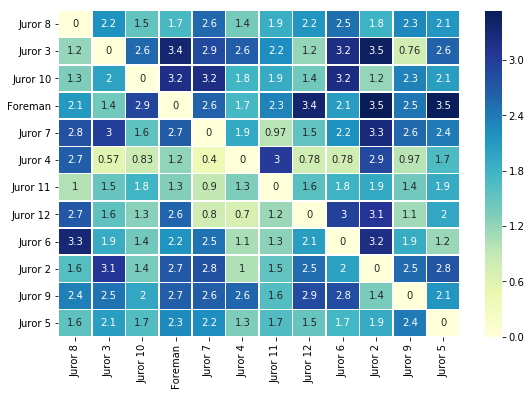

In [215]:
f, ax = plt.subplots(figsize=(9, 6))
seaborn.heatmap(df_std, annot=True,  linewidths=.5, ax=ax,cmap="YlGnBu")
print('SD of influence matrix (row=from, col=to)')
plt.show()

### Barplot of total influences sent/received

In [216]:
sender_std = {} #sd of total influence sent
reciever_std = {} #sd of total influence recieved
for i in range(A):
    reciever_std[id_person[i]] = df_influence[df_influence.columns[i::A]].sum(axis=1).std()
    sender_std[id_person[i]] = df_influence[df_influence.columns[i*A:(i+1)*A:]].sum(axis=1).std()

sent = df_mean.sum(axis=1) #mean of total influence sent
recieved =df_mean.sum(axis=0) #mean of total influence recieved

Total influence:

		Total linguistic influence sent/received 


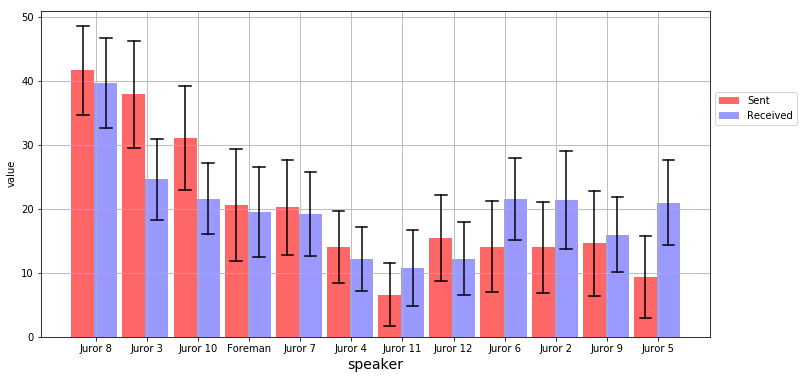

In [217]:
print ("\t\tTotal linguistic influence sent/received ")
ax.fig = plt.figure(figsize=[np.min([A,20]),6])

plt.grid()
wd=0.45
ii=0
for p in sender_std:
    plt.bar(person_id[p],sent.loc[p],width=wd,color='red',alpha=0.6,label = "Sent" if ii == 0 else "")
    plt.plot([person_id[p]-wd/4,person_id[p]+wd/4],[sent.loc[p]+sender_std[p],sent.loc[p]+sender_std[p]],color='k')
    plt.plot([person_id[p]-wd/4,person_id[p]+wd/4],[sent.loc[p]-sender_std[p],sent.loc[p]-sender_std[p]],color='k')
    plt.plot([person_id[p],person_id[p]],[sent.loc[p]-sender_std[p],sent.loc[p]+sender_std[p]],color='k')
    ii+=1
ii=0
for p in reciever_std:
    plt.bar(person_id[p]+wd,recieved.loc[p],width=wd,color='blue',alpha=0.4,label = "Received" if ii == 0 else "")
    plt.plot([person_id[p]+wd-wd/4,person_id[p]+wd+wd/4],[recieved.loc[p]+reciever_std[p],recieved.loc[p]+reciever_std[p]],color='k')
    plt.plot([person_id[p]+wd-wd/4,person_id[p]+wd+wd/4],[recieved.loc[p]-reciever_std[p],recieved.loc[p]-reciever_std[p]],color='k')
    plt.plot([person_id[p]+wd,person_id[p]+wd],[recieved.loc[p]-reciever_std[p],recieved.loc[p]+reciever_std[p]],color='k')
    ii+=1
plt.legend(loc='center left', bbox_to_anchor=(1, 0.7))
plt.xticks([i+0.25 for i in range(A)],list(zip(*sorted(id_person.items())))[1])
plt.ylabel('value')
plt.xlabel('speaker',fontsize=14)
plt.show()

## Visualize Influence Network!

You can visualize any of the influence matrices above:

Using networkx:

In [218]:
def drawNetwork(df,title):
    fig = plt.figure(figsize=[8,8])
    G = nx.DiGraph()
    for from_ in df.index:
        for to_ in df.columns:
            G.add_edge(from_,to_,weight = df.loc[from_][to_])
            
    pos = nx.spring_layout(G,k=0.55,iterations=20)
    edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())
    weights = np.array(weights)
    #weights = weights*weights
    weights = 6*weights/np.max(weights)
    print(title)
    
    edge_colors=20*(weights/np.max(weights))
    edge_colors = edge_colors.astype(int)
#     nx.draw_networkx_nodes(G,pos,node_size=1200,alpha=0.7,node_color='#99cef7')
#     nx.draw_networkx_edges(G,pos,edge_color=edge_colors)
#     nx.draw_networkx_labels(G,pos,font_weight='bold')
    nx.draw(G,pos,with_labels=True, font_weight='bold',width=weights,\
            edge_color=255-edge_colors,node_color='#99cef7',node_size=1200,\
            alpha=0.75,arrows=True,arrowsize=20)
    return edge_colors

In [219]:
# get quantile influence matrices for 25%, 50%, 75% quantile
stacked = df_influence.quantile(0.25)
df_q25 = getmatrix(stacked,A)

stacked = df_influence.quantile(0.5)
df_q50 = getmatrix(stacked,A)

stacked = df_influence.quantile(0.75)
df_q75 = getmatrix(stacked,A)

Mean Influence Network


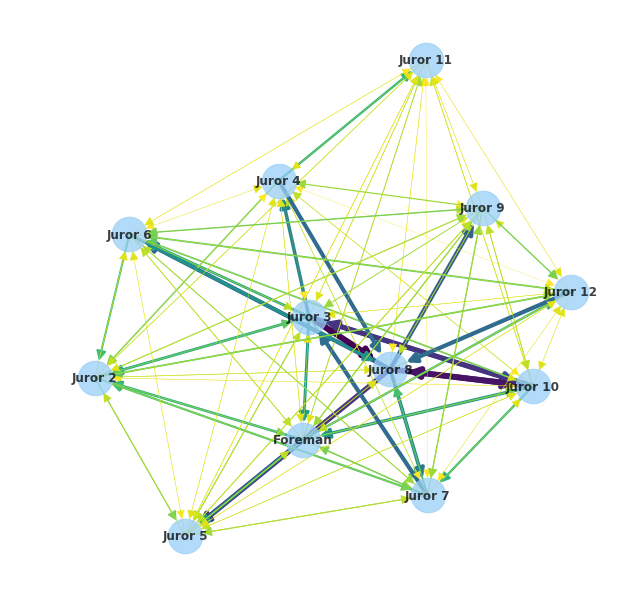

In [220]:
G_mean = drawNetwork(df_mean,'Mean Influence Network')

25 Quantile Influence Network


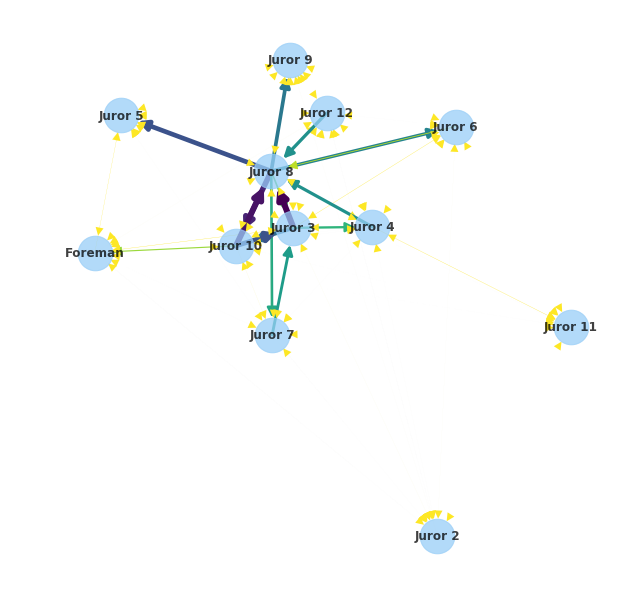

In [221]:
G_q25 = drawNetwork(df_q25,'25 Quantile Influence Network')

In [222]:
G_q75 = drawNetwork(df_q75,'75 Quantile Influence Network')

75 Quantile Influence Network


In [229]:
import lucem_illud
import pandas
def fakeEnglish(length):
    listd=['a','b','c','d','e','f','g','s','h','i','j','k','l']
    return ''.join(np.random.choice(listd,length))

def facts(length):
    liste=['My name is real', 'I am happy', 'I am sad', 'I hope to be famous one day']
    return ''.join(np.random.choice(liste,length))

Your own dataset should contains 4 columns (with the same column names) as the artificial one below:

- name: name of the participant
- tokens: a list of tokens in one utterance
- start: starting time of utterance (unit doesn't matter, can be 'seconds','minutes','hours'...)
- end: ending time of utterance (same unit as start)

There is no need to sort data for the moment.

Below, we generate a fake collection of data from "Obama", "Trump", "Clinton"...and other recent presidents. You can either create your own simulation OR (better), add real interactional data from a online chat forum, comment chain, or transcribed from a conversation.

In [227]:
script= []
language = 'eng' #parameter, no need to tune if using English, accept:{'eng','chinese'}
role = 'Adult' #parameter, no need to tune 

for i in range(290):
    dt = []
    dt.append(np.random.choice(['Obama','Trump','Clinton','Bush','Reagan','Carter','Ford','Nixon','Kennedy','Roosevelt']))
    faketokens = [fakeEnglish(length = 4) for j in range(30)]
    dt.append(faketokens) #fake utterance
    dt.append(i*2+np.random.random()) # start time
    dt.append(i*2+1+np.random.random()) # end time
    script.append(dt)

df_transcript = pandas.DataFrame(script,columns=['name','tokens','start','end']) #"start", "end" are timestamps of utterances, units don't matter
df_transcript[:5]

name                                             tokens     start  \
0   Reagan  [fksl, edkk, cabl, skeb, ijji, ddsf, bfeb, aeh...  0.170903   
1    Nixon  [hllj, clfk, alek, kisk, clsi, kdgl, fbik, bhs...  2.944568   
2  Kennedy  [ddkj, shkc, fbai, bfba, ieks, ifbj, hajd, sgd...  4.640900   
3     Ford  [eali, adic, jels, seli, khfe, allk, dfba, cbs...  6.684766   
4  Kennedy  [gcfj, bslb, kikl, dblk, kfjb, iesc, cgba, fcj...  8.466363   

        end  
0  1.248541  
1  3.876891  
2  5.587718  
3  7.264264  
4  9.551630

Transform data into TalkbankXML format:

In [225]:
output_fname = 'USpresident.xml'  #should be .xml
language = 'eng' 
#language = 'chinese'
lucem_illud.make_TalkbankXML(df_transcript, output_fname, language = language )

New File saved to ./data/USpresident/USpresident.xml


0

Run Bayesian Echo Chamber to get estimation.

- It may take a couple of hours. ( About 4-5 hours if Vocab_size=600 and sampling_time =2000)
- Larger "Vocab_size" (see below) will cost more time
- Larger "sampling_time" will also consume more time

In [226]:
Vocab_size = 90 # up to Vocab_size most frequent words will be considered, it should be smaller than the total vocab
sampling_time = 1500  #The times of Gibbs sampling sweeps  (500 burn-in not included)
lucem_illud.bec_run(output_fname, Vocab_size, language, sampling_time)

KeyboardInterrupt: 

Realtime output can be viewed in shell.

## <span style="color:red">*Exercise 4*</span>

<span style="color:red">Construct cells immediately below this that either (1) take data from a transcribed conversation, online chat forum, comment chain or some other *timed* interaction and calculate Bayesian influence; or (2) build a simulation similar in spirit to the "Presidents" example above, ideally infusing it with interesting "stylized facts". What does that estimation and its output reveal about the relative influence of each actor on others? What does it reveal about the social game being played?

In [231]:
script= []
language = 'eng' #parameter, no need to tune if using English, accept:{'eng','chinese'}
role = 'Adult' #parameter, no need to tune 

for i in range(290):
    dt = []
    dt.append(np.random.choice(['Emma Watson', 'Pablo Escobar', 'Serena Williams']))
    faketokens = [facts(length = 2) for j in range(30)]
    dt.append(faketokens) #fake utterance
    dt.append(i*2+np.random.random()) # start time
    dt.append(i*2+1+np.random.random()) # end time
    script.append(dt)

df_transcript = pandas.DataFrame(script,columns=['name','tokens','start','end']) #"start", "end" are timestamps of utterances, units don't matter
df_transcript[:2]

name                                             tokens     start  \
0  Emma Watson  [I hope to be famous one dayMy name is real, I...  0.629610   
1  Emma Watson  [I am happyMy name is real, I hope to be famou...  2.209807   

        end  
0  1.820801  
1  3.163261